In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from numpy import concatenate
from math import sqrt
from statistics import mean
import random
import matplotlib.pyplot as plt

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('/Users/alexellard/Downloads/scenarios_data.csv', header=0, index_col=0)
df

,reservoir_demand,node_1_demand,node_2_demand,node_3_demand,node_4_demand,node_5_demand,node_6_demand,node_7_demand,node_8_demand,node_9_demand,...,link_23_flow,link_24_flow,link_25_flow,link_26_flow,link_27_flow,link_28_flow,link_29_flow,link_30_flow,link_31_flow,link_32_flow
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,-3348.0,154.8,169.2,18.0,118.8,169.2,234.0,86.4,82.8,104.4,...,439.2,-205.2,-75.6,-18.0,118.8,68.4,7.2,-54.0,75.6,212.4
2017-01-01 00:30:00,-2959.2,136.8,147.6,18.0,108.0,144.0,237.6,79.2,75.6,90.0,...,392.4,-187.2,-72.0,-21.6,108.0,61.2,3.6,-54.0,72.0,183.6
2017-01-01 01:00:00,-2692.8,129.6,126.0,14.4,104.4,133.2,205.2,72.0,72.0,90.0,...,349.2,-176.4,-64.8,-18.0,93.6,50.4,3.6,-39.6,54.0,151.2
2017-01-01 01:30:00,-2379.6,104.4,100.8,10.8,86.4,122.4,180.0,68.4,57.6,82.8,...,316.8,-158.4,-54.0,-10.8,79.2,46.8,7.2,-32.4,50.4,140.4
2017-01-01 02:00:00,-2228.4,104.4,104.4,10.8,79.2,122.4,183.6,68.4,54.0,75.6,...,277.2,-144.0,-57.6,-18.0,72.0,39.6,7.2,-32.4,43.2,118.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 21:30:00,-5306.4,205.2,208.8,39.6,183.6,284.4,316.8,176.4,133.2,129.6,...,604.8,-259.2,32.4,115.2,169.2,100.8,10.8,-100.8,122.4,309.6
2017-12-31 22:00:00,-4910.4,208.8,183.6,39.6,154.8,252.0,295.2,165.6,133.2,133.2,...,565.2,-241.2,21.6,100.8,154.8,86.4,18.0,-75.6,100.8,288.0
2017-12-31 22:30:00,-4683.6,187.2,183.6,36.0,147.6,230.4,320.4,147.6,118.8,126.0,...,529.2,-226.8,21.6,100.8,147.6,86.4,14.4,-86.4,108.0,266.4


In [3]:
#average scores flows link 1

MAE_average = []
RMSE_average = []
R2_average = []
maximum_MAE = []
sensors_covered = []
n_columns_to_drop = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
for n in n_columns_to_drop:
    MAE = []
    RMSE = []
    R2 = []
    for run in range(1,11):
        Y = df[df.columns[79]]
        X = df.drop(columns=['link_16_flow'])
        X['link_16_flow'] = Y
        columns = []
        columns_to_drop = random.sample(list(X.columns), n)
        # Drop the selected columns from the dataframe
        if X.columns[-1] in columns_to_drop:
            columns_to_drop.remove(X.columns[-1])
        X.drop(columns_to_drop, axis=1, inplace=True)
        columns.append(columns_to_drop)
        print(columns)
        print('starting df shape:', X.shape)
        print(f'This is training run {run} and has the shape: ', X.shape)
        print(f'The value of dropped columns is {n}')

        # split into train and test sets
        values = X.values
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(values)
        train, test = train_test_split(scaled, test_size=0.2, random_state=0)

        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]

        #define model
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42
        )

        # fit the model on the training data
        model.fit(train_X, train_y)

        # make predictions on the test data
        y_pred = model.predict(test_X)

        test_y = test_y.reshape((len(test_y), 1))
        print('test y shape :', test_y.shape)
        inv_test_y = concatenate((test_y, test_X[:, -X.shape[1]:]), axis=1)
        print('Inv y shape :', inv_test_y.shape)
        test_y_inverse = scaler.inverse_transform(inv_test_y)
        test_y_inverse = test_y_inverse[:,0]

        y_pred = y_pred.reshape((len(y_pred), 1))
        print('y pred shape :', y_pred.shape)
        inv_y_pred = concatenate((y_pred, test_X[:, -X.shape[1]:]), axis=1)
        print('inv y pred :', inv_y_pred.shape)
        y_pred_inverse = scaler.inverse_transform(inv_y_pred)
        y_pred_inverse = y_pred_inverse[:,0]

        # evaluate scaled errors
        mae_inverse = mean_absolute_error(test_y_inverse, y_pred_inverse)
        MAE.append(mae_inverse)
        print(f'Run {run} Mean Absolute Error:', mae_inverse)
        rmse_inverse = sqrt(mean_squared_error(test_y_inverse, y_pred_inverse))
        RMSE.append(rmse_inverse)
        print('RMSE: %.3f' % rmse_inverse)
        r2_inverse = r2_score(test_y_inverse, y_pred_inverse)
        R2.append(r2_inverse)
        print('R^2: %.3f' % r2_inverse)
    percentage_list = round(X.shape[1] / 96 * 100)
    sensors_covered.append(percentage_list)
    MAE_mean = mean(MAE)
    RMSE_mean = mean(RMSE)
    R2_mean = mean(R2)
    max_MAE = max(MAE)
    maximum_MAE.append(max_MAE)
    MAE_average.append(MAE_mean)
    RMSE_average.append(RMSE_mean)
    R2_average.append(R2_mean)
print('Length MAE_average: ', len(MAE_average))
print('Length sensors_covered: ', len(sensors_covered))

[[]]
starting df shape: (87600, 96)
This is training run 1 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 1 Mean Absolute Error: 27.03572745055103
RMSE: 34.712
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 2 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 2 Mean Absolute Error: 27.03572745055103
RMSE: 34.712
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 3 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 3 Mean Absolute Error: 27.03572745055103
RMSE: 34.712
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 4 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 4 Mean Absolute Error: 27.03572745055103
RMSE: 34.712
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 5 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 5 Mean Absolute Error: 27.03572745055103
RMSE: 34.712
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 6 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 6 Mean Absolute Error: 27.03572745055103
RMSE: 34.712
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 7 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 7 Mean Absolute Error: 27.03572745055103
RMSE: 34.712
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 8 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 8 Mean Absolute Error: 27.03572745055103
RMSE: 34.712
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 9 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 9 Mean Absolute Error: 27.03572745055103
RMSE: 34.712
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 10 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 10 Mean Absolute Error: 27.03572745055103
RMSE: 34.712
R^2: 1.000
[['node_5_pressure', 'node_25_demand', 'node_30_pressure', 'node_31_demand', 'node_15_pressure']]
starting df shape: (87600, 91)
This is training run 1 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 1 Mean Absolute Error: 27.46300710764514
RMSE: 35.244
R^2: 1.000
[['node_17_demand', 'link_32_flow', 'node_28_demand', 'node_2_demand', 'link_17_flow']]
starting df shape: (87600, 91)
This is training run 2 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 2 Mean Absolute Error: 30.921215945474945
RMSE: 39.845
R^2: 0.999
[['node_12_demand', 'link_3_flow', 'node_28_demand', 'reservoir_pressure', 'node_20_demand']]
starting df shape: (87600, 91)
This is training run 3 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 3 Mean Absolute Error: 27.356913432562486
RMSE: 35.198
R^2: 1.000
[['node_28_demand', 'link_10_flow', 'node_7_pressure', 'node_21_pressure', 'reservoir_demand']]
starting df shape: (87600, 91)
This is training run 4 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 4 Mean Absolute Error: 1.6886469266525839
RMSE: 2.174
R^2: 0.999
[['link_27_flow', 'link_10_flow', 'node_12_pressure', 'node_26_pressure', 'node_3_pressure']]
starting df shape: (87600, 91)
This is training run 5 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 5 Mean Absolute Error: 27.067414094605414
RMSE: 34.677
R^2: 1.000
[['node_31_demand', 'link_30_flow', 'node_8_demand', 'node_6_demand', 'node_16_demand']]
starting df shape: (87600, 91)
This is training run 6 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 6 Mean Absolute Error: 56.695383356145285
RMSE: 74.340
R^2: 0.998
[['node_6_pressure', 'link_2_flow', 'node_24_demand', 'node_20_demand', 'node_28_pressure']]
starting df shape: (87600, 91)
This is training run 7 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 7 Mean Absolute Error: 27.70990205064427
RMSE: 35.512
R^2: 0.999
[['node_3_demand', 'node_28_pressure', 'node_12_demand', 'node_12_pressure']]
starting df shape: (87600, 92)
This is training run 8 and has the shape:  (87600, 92)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 92)
y pred shape : (17520, 1)
inv y pred : (17520, 92)
Run 8 Mean Absolute Error: 26.97712147048394
RMSE: 34.675
R^2: 1.000
[['node_27_pressure', 'node_7_demand', 'node_26_demand', 'link_17_flow', 'reservoir_demand']]
starting df shape: (87600, 91)
This is training run 9 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 9 Mean Absolute Error: 1.6732038809274907
RMSE: 2.156
R^2: 1.000
[['link_17_flow', 'node_26_pressure', 'link_26_flow', 'node_10_demand', 'node_15_demand']]
starting df shape: (87600, 91)
This is training run 10 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 10 Mean Absolute Error: 28.057731304999706
RMSE: 35.971
R^2: 0.999
[['node_20_pressure', 'node_28_demand', 'node_7_demand', 'node_23_demand', 'node_3_demand', 'node_24_pressure', 'link_32_flow', 'node_3_pressure', 'node_13_pressure', 'link_1_flow']]
starting df shape: (87600, 86)
This is training run 1 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 1 Mean Absolute Error: 27.5926823855573
RMSE: 35.410
R^2: 0.999
[['node_5_pressure', 'link_22_flow', 'link_14_flow', 'node_4_demand', 'node_4_pressure', 'link_23_flow', 'link_11_flow', 'node_1_pressure', 'node_19_demand']]
starting df shape: (87600, 87)
This is training run 2 and has the shape:  (87600, 87)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 87)
y pred shape : (17520, 1)
inv y pred : (17520, 87)
Run 2 Mean Absolute Error: 27.236646759173748
RMSE: 35.037
R^2: 1.000
[['node_4_pressure', 'node_15_demand', 'node_1_pressure', 'node_29_pressure', 'node_16_demand', 'link_6_flow', 'node_1_demand', 'node_6_pressure', 'node_27_demand', 'node_23_pressure']]
starting df shape: (87600, 86)
This is training run 3 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 3 Mean Absolute Error: 56.60806763367948
RMSE: 74.189
R^2: 0.998
[['node_14_pressure', 'link_31_flow', 'node_6_pressure', 'node_27_pressure', 'link_30_flow', 'node_2_pressure', 'reservoir_pressure', 'node_27_demand', 'link_22_flow', 'reservoir_demand']]
starting df shape: (87600, 86)
This is training run 4 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 4 Mean Absolute Error: 1.6789530898370146
RMSE: 2.166
R^2: 0.999
[['link_29_flow', 'node_27_pressure', 'node_13_pressure', 'link_10_flow', 'node_6_pressure', 'link_18_flow', 'link_12_flow', 'node_31_demand', 'node_5_pressure', 'link_6_flow']]
starting df shape: (87600, 86)
This is training run 5 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 5 Mean Absolute Error: 26.800721100505616
RMSE: 34.373
R^2: 1.000
[['node_1_pressure', 'link_29_flow', 'link_12_flow', 'link_3_flow', 'node_30_pressure', 'node_18_demand', 'node_9_pressure', 'link_14_flow', 'node_5_pressure', 'node_4_demand']]
starting df shape: (87600, 86)
This is training run 6 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 6 Mean Absolute Error: 27.16936955759384
RMSE: 34.820
R^2: 1.000
[['node_6_pressure', 'node_19_pressure', 'node_18_pressure', 'node_24_pressure', 'node_20_demand', 'node_17_pressure', 'node_1_pressure', 'link_6_flow', 'node_30_demand']]
starting df shape: (87600, 87)
This is training run 7 and has the shape:  (87600, 87)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 87)
y pred shape : (17520, 1)
inv y pred : (17520, 87)
Run 7 Mean Absolute Error: 26.925707843421804
RMSE: 34.733
R^2: 1.000
[['node_4_pressure', 'node_20_pressure', 'link_12_flow', 'node_15_pressure', 'node_26_pressure', 'node_11_pressure', 'node_13_pressure', 'node_22_demand', 'link_8_flow']]
starting df shape: (87600, 87)
This is training run 8 and has the shape:  (87600, 87)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 87)
y pred shape : (17520, 1)
inv y pred : (17520, 87)
Run 8 Mean Absolute Error: 27.457600881460806
RMSE: 35.241
R^2: 1.000
[['link_27_flow', 'node_9_demand', 'node_14_pressure', 'node_29_pressure', 'link_8_flow', 'node_11_pressure', 'link_20_flow', 'node_19_demand', 'node_15_demand', 'node_8_pressure']]
starting df shape: (87600, 86)
This is training run 9 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 9 Mean Absolute Error: 28.09026116353853
RMSE: 36.138
R^2: 0.999
[['node_30_pressure', 'link_23_flow', 'node_24_demand', 'link_6_flow', 'node_17_pressure', 'link_27_flow', 'reservoir_pressure', 'node_21_pressure', 'link_24_flow', 'node_21_demand']]
starting df shape: (87600, 86)
This is training run 10 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 10 Mean Absolute Error: 27.42587178334281
RMSE: 35.275
R^2: 1.000
[['node_24_pressure', 'node_4_demand', 'link_20_flow', 'link_24_flow', 'node_20_demand', 'link_29_flow', 'node_22_demand', 'node_10_pressure', 'node_7_pressure', 'node_19_pressure', 'node_7_demand', 'node_1_demand', 'node_25_pressure', 'node_21_demand', 'link_19_flow']]
starting df shape: (87600, 81)
This is training run 1 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 1 Mean Absolute Error: 26.884185657401552
RMSE: 34.683
R^2: 1.000
[['node_13_demand', 'node_28_pressure', 'link_1_flow', 'link_2_flow', 'link_5_flow', 'node_24_pressure', 'node_19_demand', 'link_24_flow', 'node_3_pressure', 'link_17_flow', 'reservoir_demand', 'node_26_pressure', 'node_15_pressure', 'node_14_demand', 'node_4_pressure']]
starting df shape: (87600, 81)
This is training run 2 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 2 Mean Absolute Error: 1.7762767134097883
RMSE: 2.292
R^2: 0.999
[['link_24_flow', 'node_21_pressure', 'link_5_flow', 'node_29_pressure', 'link_32_flow', 'node_24_demand', 'node_17_demand', 'node_23_pressure', 'node_12_pressure', 'node_9_demand', 'node_8_demand', 'node_26_demand', 'node_25_demand', 'link_3_flow', 'link_17_flow']]
starting df shape: (87600, 81)
This is training run 3 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 3 Mean Absolute Error: 30.43112481813083
RMSE: 39.178
R^2: 0.999
[['node_15_demand', 'link_26_flow', 'node_25_demand', 'node_23_pressure', 'link_11_flow', 'link_30_flow', 'node_13_demand', 'node_27_pressure', 'node_21_pressure', 'link_10_flow', 'link_17_flow', 'node_27_demand', 'link_2_flow', 'node_21_demand']]
starting df shape: (87600, 82)
This is training run 4 and has the shape:  (87600, 82)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)
y pred shape : (17520, 1)
inv y pred : (17520, 82)
Run 4 Mean Absolute Error: 28.200910148854735
RMSE: 36.174
R^2: 0.999
[['link_30_flow', 'node_2_pressure', 'node_20_demand', 'node_25_demand', 'node_6_pressure', 'node_31_demand', 'link_10_flow', 'link_3_flow', 'node_29_pressure', 'node_19_demand', 'node_15_demand', 'link_25_flow', 'link_14_flow', 'link_31_flow', 'node_28_pressure']]
starting df shape: (87600, 81)
This is training run 5 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 5 Mean Absolute Error: 28.23100360279581
RMSE: 36.218
R^2: 0.999
[['link_19_flow', 'node_31_pressure', 'node_4_demand', 'node_28_demand', 'node_20_pressure', 'node_12_pressure', 'link_26_flow', 'node_26_demand', 'link_25_flow', 'node_13_demand', 'node_25_pressure', 'link_14_flow', 'node_8_demand', 'link_1_flow', 'reservoir_demand']]
starting df shape: (87600, 81)
This is training run 6 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 6 Mean Absolute Error: 1.6647861824780656
RMSE: 2.137
R^2: 1.000
[['link_3_flow', 'link_14_flow', 'node_5_pressure', 'node_9_demand', 'node_25_demand', 'link_6_flow', 'node_22_demand', 'node_26_demand', 'node_29_pressure', 'node_11_pressure', 'link_26_flow', 'node_17_demand', 'node_16_demand', 'node_20_demand', 'node_2_demand']]
starting df shape: (87600, 81)
This is training run 7 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 7 Mean Absolute Error: 75.87360977919307
RMSE: 99.550
R^2: 0.996
[['node_8_pressure', 'node_13_pressure', 'node_23_pressure', 'link_3_flow', 'link_14_flow', 'node_18_pressure', 'node_9_demand', 'node_15_pressure', 'node_27_pressure', 'node_2_pressure', 'link_1_flow', 'node_23_demand', 'node_30_demand', 'link_25_flow', 'node_29_pressure']]
starting df shape: (87600, 81)
This is training run 8 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 8 Mean Absolute Error: 27.544990335335868
RMSE: 35.379
R^2: 1.000
[['node_12_pressure', 'link_26_flow', 'node_19_pressure', 'node_28_pressure', 'node_4_demand', 'node_25_demand', 'node_30_demand', 'node_10_demand', 'node_15_demand', 'node_22_demand', 'node_12_demand', 'link_9_flow', 'node_1_demand', 'link_4_flow']]
starting df shape: (87600, 82)
This is training run 9 and has the shape:  (87600, 82)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)
y pred shape : (17520, 1)
inv y pred : (17520, 82)
Run 9 Mean Absolute Error: 27.984956928566028
RMSE: 36.036
R^2: 0.999
[['link_19_flow', 'node_19_pressure', 'node_30_pressure', 'node_1_pressure', 'node_9_demand', 'node_17_pressure', 'link_31_flow', 'node_7_pressure', 'link_7_flow', 'node_2_demand', 'link_9_flow', 'node_29_demand', 'node_31_demand', 'link_18_flow', 'node_21_pressure']]
starting df shape: (87600, 81)
This is training run 10 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 10 Mean Absolute Error: 27.052869497588986
RMSE: 34.714
R^2: 1.000
[['link_27_flow', 'node_7_demand', 'node_26_pressure', 'link_8_flow', 'link_30_flow', 'link_13_flow', 'node_8_demand', 'node_13_demand', 'node_20_demand', 'link_3_flow', 'node_4_demand', 'node_26_demand', 'link_26_flow', 'node_5_pressure', 'link_6_flow', 'node_28_demand', 'link_9_flow', 'node_10_pressure', 'node_12_pressure', 'link_21_flow']]
starting df shape: (87600, 76)
This is training run 1 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 1 Mean Absolute Error: 27.760012229703676
RMSE: 35.661
R^2: 0.999
[['node_24_demand', 'node_6_demand', 'node_17_demand', 'node_27_demand', 'node_3_pressure', 'link_7_flow', 'link_20_flow', 'link_24_flow', 'node_1_pressure', 'node_21_pressure', 'node_4_demand', 'link_14_flow', 'node_26_demand', 'node_16_demand', 'link_19_flow', 'link_3_flow', 'node_25_pressure', 'node_8_demand', 'node_31_demand', 'node_29_demand']]
starting df shape: (87600, 76)
This is training run 2 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 2 Mean Absolute Error: 76.71131062604843
RMSE: 100.896
R^2: 0.996
[['node_6_pressure', 'node_27_demand', 'node_9_demand', 'node_5_pressure', 'node_15_pressure', 'node_21_pressure', 'node_25_demand', 'link_6_flow', 'node_3_pressure', 'link_18_flow', 'link_5_flow', 'link_15_flow', 'node_12_pressure', 'link_28_flow', 'node_19_pressure', 'link_14_flow', 'node_18_pressure', 'link_25_flow', 'node_11_demand', 'node_24_pressure']]
starting df shape: (87600, 76)
This is training run 3 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 3 Mean Absolute Error: 28.0697323130434
RMSE: 36.013
R^2: 0.999
[['node_25_pressure', 'node_31_pressure', 'node_28_pressure', 'node_7_pressure', 'link_4_flow', 'node_8_demand', 'node_9_pressure', 'node_14_pressure', 'node_28_demand', 'link_6_flow', 'link_5_flow', 'node_15_demand', 'node_26_demand', 'node_2_pressure', 'node_22_pressure', 'link_19_flow', 'link_21_flow', 'link_28_flow', 'node_22_demand', 'node_20_demand']]
starting df shape: (87600, 76)
This is training run 4 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 4 Mean Absolute Error: 28.31478952406237
RMSE: 36.220
R^2: 0.999
[['node_22_pressure', 'node_7_demand', 'node_30_pressure', 'link_19_flow', 'node_28_demand', 'node_2_pressure', 'node_12_pressure', 'node_17_pressure', 'node_31_pressure', 'node_1_demand', 'node_12_demand', 'link_18_flow', 'node_13_demand', 'link_27_flow', 'node_9_pressure', 'link_6_flow', 'node_18_pressure', 'link_32_flow', 'link_2_flow', 'node_6_demand']]
starting df shape: (87600, 76)
This is training run 5 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 5 Mean Absolute Error: 27.864907722399995
RMSE: 35.710
R^2: 0.999
[['link_20_flow', 'link_23_flow', 'link_17_flow', 'node_23_pressure', 'node_19_pressure', 'node_17_pressure', 'node_17_demand', 'node_11_demand', 'node_27_demand', 'node_20_demand', 'link_21_flow', 'node_8_demand', 'node_26_pressure', 'node_15_pressure', 'node_11_pressure', 'node_31_pressure', 'node_9_pressure', 'reservoir_pressure', 'node_13_pressure', 'link_26_flow']]
starting df shape: (87600, 76)
This is training run 6 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 6 Mean Absolute Error: 30.64685141604688
RMSE: 39.560
R^2: 0.999
[['node_5_demand', 'node_27_demand', 'node_31_pressure', 'link_5_flow', 'link_11_flow', 'node_13_pressure', 'link_30_flow', 'reservoir_pressure', 'node_9_demand', 'node_4_demand', 'node_12_pressure', 'link_18_flow', 'node_27_pressure', 'node_6_pressure', 'node_2_pressure', 'node_2_demand', 'node_21_pressure', 'link_29_flow', 'node_28_pressure']]
starting df shape: (87600, 77)
This is training run 7 and has the shape:  (87600, 77)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 77)
y pred shape : (17520, 1)
inv y pred : (17520, 77)
Run 7 Mean Absolute Error: 27.50317037631063
RMSE: 35.453
R^2: 0.999
[['link_12_flow', 'link_2_flow', 'link_17_flow', 'node_30_demand', 'node_4_demand', 'node_26_pressure', 'node_21_demand', 'node_14_demand', 'link_19_flow', 'node_29_pressure', 'link_25_flow', 'node_2_pressure', 'node_27_demand', 'node_13_demand', 'node_19_pressure', 'node_31_demand', 'node_23_pressure', 'node_23_demand', 'link_22_flow', 'node_28_demand']]
starting df shape: (87600, 76)
This is training run 8 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 8 Mean Absolute Error: 28.367640184857898
RMSE: 36.316
R^2: 0.999
[['node_3_pressure', 'link_18_flow', 'node_9_demand', 'node_13_pressure', 'node_2_demand', 'link_12_flow', 'link_32_flow', 'link_17_flow', 'link_28_flow', 'node_23_demand', 'node_1_pressure', 'reservoir_demand', 'node_8_demand', 'node_11_pressure', 'node_20_demand', 'link_7_flow', 'reservoir_pressure', 'node_26_pressure', 'link_26_flow', 'node_10_pressure']]
starting df shape: (87600, 76)
This is training run 9 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 9 Mean Absolute Error: 1.6559588415046296
RMSE: 2.133
R^2: 1.000
[['link_14_flow', 'node_30_pressure', 'node_8_demand', 'node_3_demand', 'node_18_demand', 'link_5_flow', 'node_16_pressure', 'link_10_flow', 'link_18_flow', 'node_11_pressure', 'node_26_demand', 'link_8_flow', 'node_20_demand', 'node_20_pressure', 'node_28_demand', 'node_9_pressure', 'node_27_demand', 'reservoir_pressure', 'link_21_flow', 'node_1_demand']]
starting df shape: (87600, 76)
This is training run 10 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 10 Mean Absolute Error: 27.13449795213201
RMSE: 34.829
R^2: 1.000
[['node_28_demand', 'node_31_demand', 'node_2_demand', 'node_27_pressure', 'reservoir_demand', 'link_11_flow', 'node_5_demand', 'node_12_pressure', 'link_19_flow', 'node_5_pressure', 'node_22_pressure', 'link_4_flow', 'node_15_demand', 'node_29_pressure', 'node_4_pressure', 'node_24_demand', 'node_19_demand', 'node_9_demand', 'link_17_flow', 'link_28_flow', 'node_10_demand', 'node_23_demand', 'node_15_pressure', 'node_1_demand', 'node_1_pressure']]
starting df shape: (87600, 71)
This is training run 1 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 1 Mean Absolute Error: 0.24671790129963728
RMSE: 0.317
R^2: 0.999
[['node_25_pressure', 'link_5_flow', 'link_17_flow', 'node_22_demand', 'node_17_demand', 'node_2_demand', 'node_9_pressure', 'link_8_flow', 'node_4_pressure', 'node_29_demand', 'node_11_demand', 'link_13_flow', 'node_5_pressure', 'link_4_flow', 'node_9_demand', 'node_14_demand', 'link_30_flow', 'node_18_demand', 'node_21_pressure', 'node_24_pressure', 'node_19_demand', 'link_19_flow', 'link_22_flow', 'node_26_pressure', 'reservoir_pressure']]
starting df shape: (87600, 71)
This is training run 2 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 2 Mean Absolute Error: 30.89010544790181
RMSE: 39.746
R^2: 0.999
[['link_1_flow', 'link_23_flow', 'reservoir_pressure', 'node_11_pressure', 'node_31_pressure', 'node_20_pressure', 'node_19_demand', 'node_4_pressure', 'node_15_demand', 'link_6_flow', 'reservoir_demand', 'node_9_pressure', 'node_17_demand', 'node_28_demand', 'node_7_pressure', 'node_1_demand', 'link_30_flow', 'node_28_pressure', 'node_13_pressure', 'link_24_flow', 'node_5_pressure', 'node_27_pressure', 'node_15_pressure', 'node_18_pressure', 'node_6_demand']]
starting df shape: (87600, 71)
This is training run 3 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 3 Mean Absolute Error: 1.715209095463598
RMSE: 2.206
R^2: 0.999
[['node_4_demand', 'link_4_flow', 'node_31_pressure', 'node_12_demand', 'node_19_pressure', 'node_16_demand', 'link_11_flow', 'node_3_pressure', 'node_30_demand', 'link_8_flow', 'link_7_flow', 'link_20_flow', 'node_22_pressure', 'node_7_demand', 'node_27_pressure', 'node_5_demand', 'node_13_pressure', 'node_15_pressure', 'link_12_flow', 'reservoir_pressure', 'node_20_pressure', 'link_19_flow', 'link_27_flow', 'node_24_pressure']]
starting df shape: (87600, 72)
This is training run 4 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 4 Mean Absolute Error: 56.611499330006026
RMSE: 74.216
R^2: 0.998
[['node_17_demand', 'node_22_demand', 'link_14_flow', 'node_11_demand', 'link_9_flow', 'link_4_flow', 'node_28_demand', 'node_3_demand', 'node_13_demand', 'link_7_flow', 'node_16_pressure', 'node_11_pressure', 'node_22_pressure', 'node_30_demand', 'node_23_demand', 'link_18_flow', 'node_8_pressure', 'node_31_demand', 'node_9_pressure', 'link_19_flow', 'node_5_demand', 'link_30_flow', 'node_4_pressure', 'node_4_demand', 'node_12_demand']]
starting df shape: (87600, 71)
This is training run 5 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 5 Mean Absolute Error: 30.601326166885777
RMSE: 39.362
R^2: 0.999
[['node_3_demand', 'link_19_flow', 'node_10_pressure', 'link_2_flow', 'node_25_pressure', 'node_16_demand', 'node_7_demand', 'link_31_flow', 'link_20_flow', 'node_31_pressure', 'node_8_pressure', 'node_8_demand', 'node_20_pressure', 'link_23_flow', 'node_30_pressure', 'link_29_flow', 'link_14_flow', 'node_4_demand', 'node_18_pressure', 'link_27_flow', 'link_5_flow', 'link_12_flow', 'node_24_demand', 'node_17_demand', 'node_20_demand']]
starting df shape: (87600, 71)
This is training run 6 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 6 Mean Absolute Error: 76.82767819376772
RMSE: 101.262
R^2: 0.996
[['link_21_flow', 'node_6_demand', 'link_12_flow', 'link_13_flow', 'node_17_demand', 'node_14_demand', 'node_26_pressure', 'node_4_demand', 'link_31_flow', 'node_17_pressure', 'node_20_demand', 'node_21_demand', 'node_2_pressure', 'node_3_pressure', 'node_19_demand', 'link_19_flow', 'node_29_demand', 'node_5_demand', 'link_14_flow', 'link_30_flow', 'node_13_demand', 'link_24_flow', 'node_18_pressure', 'node_9_demand', 'link_4_flow']]
starting df shape: (87600, 71)
This is training run 7 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 7 Mean Absolute Error: 31.428532300574506
RMSE: 40.311
R^2: 0.999
[['node_27_pressure', 'node_18_pressure', 'link_31_flow', 'node_25_pressure', 'link_23_flow', 'link_13_flow', 'node_25_demand', 'node_8_demand', 'node_12_demand', 'node_2_pressure', 'node_29_demand', 'node_23_pressure', 'reservoir_demand', 'link_20_flow', 'link_6_flow', 'node_26_pressure', 'link_15_flow', 'link_29_flow', 'node_21_pressure', 'node_3_pressure', 'link_7_flow', 'link_17_flow', 'node_15_demand', 'node_21_demand']]
starting df shape: (87600, 72)
This is training run 8 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 8 Mean Absolute Error: 1.7440209104598756
RMSE: 2.237
R^2: 0.999
[['node_4_demand', 'node_19_pressure', 'link_13_flow', 'node_13_pressure', 'node_1_demand', 'node_18_demand', 'link_14_flow', 'link_6_flow', 'node_22_pressure', 'node_6_pressure', 'node_1_pressure', 'node_17_pressure', 'link_18_flow', 'node_29_pressure', 'link_31_flow', 'node_10_demand', 'node_12_pressure', 'node_21_pressure', 'link_24_flow', 'reservoir_demand', 'node_10_pressure', 'node_29_demand', 'node_22_demand', 'link_30_flow', 'link_12_flow']]
starting df shape: (87600, 71)
This is training run 9 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 9 Mean Absolute Error: 1.4923972549289526
RMSE: 1.908
R^2: 1.000
[['link_15_flow', 'node_17_pressure', 'node_31_pressure', 'node_5_pressure', 'node_1_pressure', 'node_30_demand', 'link_12_flow', 'link_7_flow', 'node_10_demand', 'node_4_demand', 'node_24_demand', 'node_6_demand', 'node_18_pressure', 'node_29_demand', 'node_20_pressure', 'node_23_pressure', 'node_22_pressure', 'link_17_flow', 'node_7_demand', 'node_2_demand', 'link_5_flow', 'node_9_pressure', 'node_1_demand', 'node_3_pressure', 'link_24_flow']]
starting df shape: (87600, 71)
This is training run 10 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 10 Mean Absolute Error: 28.158064013263406
RMSE: 36.170
R^2: 0.999
[['link_29_flow', 'node_5_pressure', 'link_27_flow', 'node_11_pressure', 'link_30_flow', 'node_2_pressure', 'link_9_flow', 'node_27_demand', 'node_18_demand', 'link_23_flow', 'node_21_pressure', 'link_12_flow', 'node_28_demand', 'link_3_flow', 'node_20_demand', 'node_19_pressure', 'node_21_demand', 'node_10_pressure', 'node_10_demand', 'node_14_pressure', 'node_25_demand', 'node_26_demand', 'node_24_demand', 'link_8_flow', 'node_9_pressure', 'link_26_flow', 'link_25_flow', 'link_7_flow', 'node_20_pressure', 'link_4_flow']]
starting df shape: (87600, 66)
This is training run 1 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 1 Mean Absolute Error: 26.88516759241403
RMSE: 34.399
R^2: 1.000
[['link_18_flow', 'node_16_demand', 'node_27_demand', 'link_6_flow', 'node_25_pressure', 'link_31_flow', 'link_21_flow', 'link_3_flow', 'link_27_flow', 'link_15_flow', 'node_21_pressure', 'node_9_demand', 'node_30_demand', 'node_17_demand', 'node_11_demand', 'node_17_pressure', 'link_26_flow', 'node_24_pressure', 'link_2_flow', 'reservoir_pressure', 'node_20_demand', 'link_29_flow', 'link_8_flow', 'link_30_flow', 'node_28_demand', 'node_3_pressure', 'node_14_pressure', 'link_20_flow', 'node_22_demand', 'node_8_pressure']]
starting df shape: (87600, 66)
This is training run 2 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 2 Mean Absolute Error: 82.49161666681063
RMSE: 108.267
R^2: 0.995
[['link_23_flow', 'node_30_demand', 'node_16_demand', 'link_6_flow', 'node_27_demand', 'link_17_flow', 'node_13_demand', 'node_31_pressure', 'reservoir_demand', 'link_5_flow', 'node_29_pressure', 'link_9_flow', 'node_13_pressure', 'node_29_demand', 'link_20_flow', 'link_13_flow', 'link_32_flow', 'node_2_demand', 'node_28_demand', 'node_21_demand', 'node_24_pressure', 'node_11_demand', 'link_7_flow', 'node_2_pressure', 'node_8_demand', 'node_27_pressure', 'link_1_flow', 'link_10_flow', 'link_18_flow']]
starting df shape: (87600, 67)
This is training run 3 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 3 Mean Absolute Error: 4.042958002651182
RMSE: 5.306
R^2: 0.997
[['link_21_flow', 'node_17_pressure', 'link_9_flow', 'node_3_demand', 'node_14_demand', 'node_31_pressure', 'link_31_flow', 'node_27_demand', 'node_20_pressure', 'node_11_pressure', 'link_24_flow', 'node_15_demand', 'node_12_demand', 'link_20_flow', 'link_18_flow', 'link_2_flow', 'node_22_pressure', 'link_15_flow', 'node_2_pressure', 'node_28_pressure', 'node_15_pressure', 'node_16_pressure', 'link_8_flow', 'node_29_pressure', 'node_3_pressure', 'node_6_demand', 'link_4_flow', 'node_14_pressure', 'link_12_flow']]
starting df shape: (87600, 67)
This is training run 4 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 4 Mean Absolute Error: 29.470428503510494
RMSE: 37.833
R^2: 0.999
[['node_19_demand', 'link_14_flow', 'link_25_flow', 'link_8_flow', 'node_24_pressure', 'node_20_demand', 'node_10_demand', 'link_17_flow', 'reservoir_demand', 'node_15_pressure', 'node_29_demand', 'node_5_pressure', 'node_12_demand', 'node_17_demand', 'node_21_pressure', 'link_4_flow', 'node_27_demand', 'node_11_demand', 'node_29_pressure', 'link_31_flow', 'node_20_pressure', 'node_1_demand', 'link_23_flow', 'link_27_flow', 'link_22_flow', 'link_9_flow', 'node_7_demand', 'node_5_demand', 'link_26_flow']]
starting df shape: (87600, 67)
This is training run 5 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 5 Mean Absolute Error: 1.687013797814029
RMSE: 2.171
R^2: 0.999
[['node_3_demand', 'link_11_flow', 'node_25_demand', 'node_19_pressure', 'link_20_flow', 'node_5_demand', 'reservoir_pressure', 'link_29_flow', 'node_22_pressure', 'node_16_demand', 'node_27_pressure', 'node_18_pressure', 'node_10_demand', 'link_32_flow', 'node_20_pressure', 'node_23_demand', 'node_26_pressure', 'node_8_pressure', 'node_14_demand', 'link_4_flow', 'node_17_demand', 'link_13_flow', 'link_22_flow', 'node_7_demand', 'link_28_flow', 'node_9_pressure', 'node_31_pressure', 'link_27_flow', 'link_3_flow', 'link_6_flow']]
starting df shape: (87600, 66)
This is training run 6 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 6 Mean Absolute Error: 76.4765431738089
RMSE: 100.453
R^2: 0.996
[['node_18_demand', 'node_23_demand', 'link_6_flow', 'node_11_pressure', 'node_2_pressure', 'node_4_demand', 'node_22_pressure', 'node_1_pressure', 'link_11_flow', 'link_23_flow', 'link_20_flow', 'node_8_demand', 'link_9_flow', 'node_18_pressure', 'node_24_demand', 'link_15_flow', 'node_26_demand', 'node_21_demand', 'link_27_flow', 'node_24_pressure', 'node_3_pressure', 'link_3_flow', 'node_11_demand', 'node_3_demand', 'link_5_flow', 'node_26_pressure', 'node_4_pressure', 'node_9_demand', 'node_19_demand']]
starting df shape: (87600, 67)
This is training run 7 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 7 Mean Absolute Error: 27.152164828001393
RMSE: 34.902
R^2: 1.000
[['link_23_flow', 'node_5_pressure', 'link_9_flow', 'link_5_flow', 'link_26_flow', 'node_30_pressure', 'link_17_flow', 'node_4_pressure', 'node_30_demand', 'link_12_flow', 'node_1_demand', 'node_15_demand', 'node_20_pressure', 'node_8_demand', 'node_31_pressure', 'node_31_demand', 'link_21_flow', 'link_32_flow', 'node_29_pressure', 'node_5_demand', 'node_24_demand', 'link_20_flow', 'node_13_demand', 'node_28_pressure', 'node_26_demand', 'link_8_flow', 'node_2_pressure', 'node_19_demand', 'node_20_demand']]
starting df shape: (87600, 67)
This is training run 8 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 8 Mean Absolute Error: 28.082056518595778
RMSE: 36.026
R^2: 0.999
[['node_17_pressure', 'link_21_flow', 'node_3_demand', 'link_8_flow', 'link_9_flow', 'node_6_pressure', 'link_13_flow', 'node_9_pressure', 'node_1_demand', 'node_16_demand', 'node_18_demand', 'node_13_demand', 'node_9_demand', 'link_5_flow', 'node_25_pressure', 'link_2_flow', 'link_4_flow', 'link_31_flow', 'node_7_demand', 'link_22_flow', 'link_18_flow', 'link_30_flow', 'node_4_pressure', 'node_22_demand', 'node_21_pressure', 'node_26_demand', 'link_29_flow', 'node_2_demand', 'node_20_demand']]
starting df shape: (87600, 67)
This is training run 9 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 9 Mean Absolute Error: 56.807703110149724
RMSE: 74.562
R^2: 0.998
[['node_14_pressure', 'node_3_pressure', 'node_3_demand', 'node_29_pressure', 'node_4_demand', 'node_20_pressure', 'link_25_flow', 'reservoir_pressure', 'node_8_pressure', 'node_20_demand', 'link_3_flow', 'link_2_flow', 'node_10_demand', 'node_17_pressure', 'node_8_demand', 'link_14_flow', 'node_24_pressure', 'node_15_pressure', 'link_19_flow', 'link_6_flow', 'node_28_pressure', 'link_20_flow', 'node_16_pressure', 'node_7_pressure', 'node_25_demand', 'node_14_demand', 'node_2_pressure', 'link_28_flow', 'node_18_demand']]
starting df shape: (87600, 67)
This is training run 10 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 10 Mean Absolute Error: 28.06215291842298
RMSE: 35.964
R^2: 0.999
[['node_14_pressure', 'link_3_flow', 'node_19_pressure', 'node_27_pressure', 'link_18_flow', 'node_3_demand', 'link_5_flow', 'node_24_demand', 'link_26_flow', 'node_20_demand', 'link_14_flow', 'node_25_demand', 'node_31_pressure', 'node_22_demand', 'node_7_demand', 'link_15_flow', 'node_11_demand', 'node_21_pressure', 'link_13_flow', 'reservoir_pressure', 'link_2_flow', 'link_28_flow', 'link_22_flow', 'link_9_flow', 'node_23_pressure', 'node_17_pressure', 'node_9_pressure', 'link_4_flow', 'node_5_pressure', 'node_1_demand', 'node_2_demand', 'node_18_pressure', 'link_6_flow', 'node_15_demand', 'link_12_flow']]
starting df shape: (87600, 61)
This is training run 1 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 1 Mean Absolute Error: 29.386530345854283
RMSE: 37.770
R^2: 0.999
[['link_12_flow', 'link_13_flow', 'node_7_pressure', 'node_5_demand', 'reservoir_pressure', 'link_19_flow', 'node_26_pressure', 'node_31_pressure', 'link_31_flow', 'node_23_pressure', 'node_30_demand', 'link_18_flow', 'node_19_demand', 'node_4_demand', 'node_31_demand', 'node_29_demand', 'node_15_pressure', 'node_12_demand', 'node_12_pressure', 'node_24_demand', 'link_21_flow', 'node_16_demand', 'link_11_flow', 'node_25_demand', 'link_3_flow', 'node_13_pressure', 'link_15_flow', 'node_16_pressure', 'link_20_flow', 'node_11_demand', 'node_22_pressure', 'node_27_demand', 'node_29_pressure', 'link_29_flow']]
starting df shape: (87600, 62)
This is training run 2 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 2 Mean Absolute Error: 62.40679826129774
RMSE: 81.394
R^2: 0.997
[['node_20_demand', 'reservoir_pressure', 'node_24_demand', 'link_9_flow', 'link_32_flow', 'link_12_flow', 'link_30_flow', 'node_19_demand', 'node_31_demand', 'node_8_demand', 'link_17_flow', 'node_14_demand', 'node_25_demand', 'node_9_demand', 'link_10_flow', 'node_27_demand', 'node_17_demand', 'node_17_pressure', 'node_4_demand', 'node_9_pressure', 'node_23_pressure', 'link_26_flow', 'node_16_demand', 'node_20_pressure', 'node_21_demand', 'node_30_pressure', 'reservoir_demand', 'node_29_demand', 'node_26_pressure', 'node_13_pressure', 'link_23_flow', 'node_11_pressure', 'node_28_demand', 'link_5_flow', 'node_18_demand']]
starting df shape: (87600, 61)
This is training run 3 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 3 Mean Absolute Error: 4.7053123633734675
RMSE: 6.203
R^2: 0.996
[['node_14_pressure', 'link_10_flow', 'link_9_flow', 'node_5_pressure', 'link_25_flow', 'node_21_demand', 'node_18_pressure', 'node_26_pressure', 'node_30_demand', 'link_1_flow', 'node_18_demand', 'link_12_flow', 'node_3_demand', 'node_22_demand', 'node_23_demand', 'node_24_pressure', 'link_24_flow', 'node_19_demand', 'node_8_pressure', 'node_2_pressure', 'node_31_pressure', 'link_19_flow', 'node_13_pressure', 'node_30_pressure', 'link_29_flow', 'node_16_pressure', 'node_15_pressure', 'node_11_demand', 'node_21_pressure', 'node_4_demand', 'link_15_flow', 'node_14_demand', 'node_25_pressure', 'node_1_demand']]
starting df shape: (87600, 62)
This is training run 4 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 4 Mean Absolute Error: 28.07425654895566
RMSE: 36.159
R^2: 0.999
[['node_24_pressure', 'node_4_demand', 'node_6_demand', 'link_17_flow', 'node_10_demand', 'link_32_flow', 'node_27_pressure', 'node_10_pressure', 'node_8_demand', 'node_3_demand', 'node_12_demand', 'link_1_flow', 'node_15_pressure', 'node_1_pressure', 'node_13_pressure', 'node_11_demand', 'link_29_flow', 'link_30_flow', 'node_11_pressure', 'node_12_pressure', 'node_19_demand', 'link_22_flow', 'node_17_pressure', 'node_6_pressure', 'node_29_demand', 'link_5_flow', 'node_9_pressure', 'node_29_pressure', 'node_14_demand', 'link_28_flow', 'node_20_pressure', 'link_12_flow', 'node_22_demand', 'node_30_demand', 'link_25_flow']]
starting df shape: (87600, 61)
This is training run 5 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 5 Mean Absolute Error: 27.635382752497023
RMSE: 35.493
R^2: 0.999
[['link_5_flow', 'node_9_demand', 'node_29_demand', 'link_21_flow', 'link_14_flow', 'node_7_pressure', 'link_19_flow', 'node_3_demand', 'node_30_pressure', 'link_23_flow', 'node_11_demand', 'link_6_flow', 'node_24_demand', 'link_12_flow', 'link_15_flow', 'node_20_demand', 'node_25_pressure', 'link_11_flow', 'node_23_demand', 'node_19_pressure', 'node_17_pressure', 'link_18_flow', 'node_13_pressure', 'link_29_flow', 'node_7_demand', 'node_12_demand', 'node_14_demand', 'node_16_pressure', 'node_18_demand', 'link_9_flow', 'node_22_demand', 'node_27_demand', 'node_25_demand', 'node_19_demand', 'node_28_pressure']]
starting df shape: (87600, 61)
This is training run 6 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 6 Mean Absolute Error: 27.9245103342053
RMSE: 35.798
R^2: 0.999
[['node_30_demand', 'node_25_demand', 'node_27_pressure', 'link_9_flow', 'node_12_pressure', 'link_20_flow', 'node_13_pressure', 'link_17_flow', 'link_27_flow', 'node_16_pressure', 'link_18_flow', 'reservoir_pressure', 'node_6_demand', 'link_23_flow', 'node_10_demand', 'node_1_demand', 'node_29_pressure', 'link_8_flow', 'node_20_demand', 'reservoir_demand', 'node_4_pressure', 'link_2_flow', 'link_19_flow', 'link_15_flow', 'node_15_demand', 'link_26_flow', 'node_31_pressure', 'link_14_flow', 'node_24_demand', 'link_31_flow', 'link_12_flow', 'link_32_flow', 'link_3_flow', 'node_17_pressure']]
starting df shape: (87600, 62)
This is training run 7 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 7 Mean Absolute Error: 1.6132143074820986
RMSE: 2.067
R^2: 0.999
[['node_29_pressure', 'node_7_pressure', 'node_15_demand', 'node_31_pressure', 'node_3_demand', 'node_9_pressure', 'node_16_pressure', 'node_2_demand', 'node_11_pressure', 'node_28_pressure', 'link_31_flow', 'node_28_demand', 'node_25_pressure', 'node_30_demand', 'node_15_pressure', 'node_7_demand', 'node_20_demand', 'node_24_pressure', 'link_32_flow', 'link_21_flow', 'node_21_pressure', 'link_25_flow', 'node_11_demand', 'node_16_demand', 'node_19_pressure', 'node_13_demand', 'node_18_pressure', 'link_14_flow', 'link_19_flow', 'node_18_demand', 'node_17_pressure', 'link_9_flow', 'node_3_pressure', 'node_27_pressure']]
starting df shape: (87600, 62)
This is training run 8 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 8 Mean Absolute Error: 55.869446595528785
RMSE: 73.097
R^2: 0.998
[['link_6_flow', 'node_15_demand', 'node_3_demand', 'link_15_flow', 'node_3_pressure', 'link_11_flow', 'node_10_demand', 'node_4_demand', 'link_20_flow', 'link_14_flow', 'node_12_pressure', 'node_21_demand', 'node_24_demand', 'link_5_flow', 'node_27_pressure', 'node_5_pressure', 'node_29_demand', 'link_12_flow', 'link_2_flow', 'node_5_demand', 'node_18_pressure', 'node_19_pressure', 'link_3_flow', 'link_27_flow', 'node_7_pressure', 'node_22_pressure', 'link_18_flow', 'link_17_flow', 'node_14_demand', 'node_13_pressure', 'node_23_demand', 'link_21_flow', 'link_7_flow', 'link_24_flow']]
starting df shape: (87600, 62)
This is training run 9 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 9 Mean Absolute Error: 29.425304579587916
RMSE: 37.738
R^2: 0.999
[['link_2_flow', 'node_23_pressure', 'node_8_demand', 'node_9_demand', 'link_14_flow', 'link_12_flow', 'node_13_demand', 'link_3_flow', 'node_29_pressure', 'node_7_demand', 'node_27_demand', 'link_26_flow', 'link_7_flow', 'link_13_flow', 'node_31_demand', 'node_5_demand', 'link_30_flow', 'link_6_flow', 'node_11_pressure', 'link_4_flow', 'node_24_pressure', 'node_19_demand', 'node_26_demand', 'link_23_flow', 'node_25_demand', 'link_22_flow', 'node_22_demand', 'link_11_flow', 'link_5_flow', 'link_31_flow', 'link_32_flow', 'node_25_pressure', 'node_13_pressure', 'node_22_pressure']]
starting df shape: (87600, 62)
This is training run 10 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 10 Mean Absolute Error: 27.959074126118402
RMSE: 35.831
R^2: 0.999
[['link_20_flow', 'node_3_demand', 'node_19_demand', 'link_6_flow', 'node_2_demand', 'node_24_pressure', 'node_8_pressure', 'link_17_flow', 'link_23_flow', 'reservoir_pressure', 'node_11_demand', 'node_23_pressure', 'link_21_flow', 'node_30_demand', 'link_15_flow', 'link_19_flow', 'node_17_demand', 'node_15_pressure', 'node_25_demand', 'node_20_pressure', 'node_13_pressure', 'node_26_demand', 'node_1_pressure', 'node_16_pressure', 'node_31_pressure', 'link_27_flow', 'node_23_demand', 'node_21_pressure', 'node_5_demand', 'node_10_demand', 'node_18_pressure', 'link_26_flow', 'link_8_flow', 'link_24_flow', 'node_22_demand', 'link_25_flow', 'link_29_flow', 'node_20_demand', 'node_27_demand', 'node_14_pressure']]
starting df shape: (87600, 56)
This is training run 1 and has the shape:  (87600, 56)
The value of dropped c

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 1 Mean Absolute Error: 32.8677321267914
RMSE: 42.224
R^2: 0.999
[['link_27_flow', 'node_17_demand', 'node_3_pressure', 'node_8_pressure', 'node_23_pressure', 'node_3_demand', 'link_9_flow', 'link_23_flow', 'node_24_pressure', 'node_5_demand', 'node_27_pressure', 'node_14_demand', 'node_21_demand', 'node_5_pressure', 'link_1_flow', 'node_2_pressure', 'node_20_pressure', 'node_25_demand', 'link_32_flow', 'link_19_flow', 'link_18_flow', 'link_31_flow', 'node_18_demand', 'link_29_flow', 'link_24_flow', 'node_14_pressure', 'link_28_flow', 'node_1_pressure', 'node_9_pressure', 'link_22_flow', 'link_14_flow', 'link_8_flow', 'node_8_demand', 'link_13_flow', 'node_6_demand', 'node_27_demand', 'node_26_pressure', 'node_18_pressure', 'link_20_flow', 'node_24_demand']]
starting df shape: (87600, 56)
This is training run 2 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 2 Mean Absolute Error: 31.974236177868995
RMSE: 41.191
R^2: 0.999
[['node_17_demand', 'node_10_demand', 'node_25_pressure', 'node_25_demand', 'node_21_demand', 'link_17_flow', 'node_22_demand', 'reservoir_pressure', 'node_12_pressure', 'node_13_pressure', 'node_4_pressure', 'node_15_pressure', 'link_11_flow', 'node_27_demand', 'link_6_flow', 'node_14_pressure', 'link_19_flow', 'node_21_pressure', 'node_18_pressure', 'node_9_pressure', 'link_5_flow', 'node_4_demand', 'node_8_demand', 'node_29_pressure', 'node_1_demand', 'link_30_flow', 'node_2_demand', 'link_28_flow', 'node_18_demand', 'node_19_pressure', 'node_16_demand', 'node_3_pressure', 'node_3_demand', 'node_22_pressure', 'link_7_flow', 'link_8_flow', 'node_14_demand', 'link_23_flow', 'link_15_flow', 'node_16_pressure']]
starting df shape: (87600, 56)
This is training run 3 and has the shape:  (87600, 56)
The value of dropped

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 3 Mean Absolute Error: 82.41710234535473
RMSE: 108.619
R^2: 0.995
[['node_21_demand', 'node_10_pressure', 'link_32_flow', 'node_25_pressure', 'node_28_pressure', 'link_24_flow', 'node_24_pressure', 'link_5_flow', 'node_14_demand', 'node_16_demand', 'node_29_pressure', 'node_17_demand', 'node_9_pressure', 'node_25_demand', 'node_1_demand', 'node_19_pressure', 'node_7_pressure', 'node_2_demand', 'node_13_demand', 'node_28_demand', 'link_14_flow', 'node_5_pressure', 'node_8_demand', 'node_15_pressure', 'node_20_pressure', 'link_6_flow', 'link_19_flow', 'link_4_flow', 'node_15_demand', 'node_30_demand', 'link_15_flow', 'node_16_pressure', 'link_30_flow', 'node_6_pressure', 'node_22_demand', 'node_27_demand', 'node_21_pressure', 'reservoir_demand', 'node_11_pressure']]
starting df shape: (87600, 57)
This is training run 4 and has the shape:  (87600, 57)
The value of dropped columns is 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 4 Mean Absolute Error: 0.7503573040554948
RMSE: 0.988
R^2: 0.995
[['node_16_demand', 'link_6_flow', 'node_3_demand', 'link_12_flow', 'link_15_flow', 'link_23_flow', 'node_1_demand', 'node_16_pressure', 'node_30_pressure', 'link_21_flow', 'node_11_pressure', 'node_14_demand', 'link_3_flow', 'node_8_pressure', 'node_27_pressure', 'node_12_pressure', 'node_13_demand', 'node_24_demand', 'link_11_flow', 'node_14_pressure', 'node_5_pressure', 'link_19_flow', 'node_24_pressure', 'link_24_flow', 'link_27_flow', 'link_26_flow', 'node_26_demand', 'node_11_demand', 'node_28_pressure', 'link_32_flow', 'link_7_flow', 'node_29_pressure', 'node_30_demand', 'link_28_flow', 'link_9_flow', 'link_1_flow', 'node_9_demand', 'node_13_pressure', 'node_1_pressure', 'node_10_demand']]
starting df shape: (87600, 56)
This is training run 5 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 5 Mean Absolute Error: 60.98427188438612
RMSE: 79.293
R^2: 0.997
[['link_15_flow', 'link_1_flow', 'link_21_flow', 'node_19_demand', 'node_4_demand', 'node_25_pressure', 'node_27_demand', 'node_3_demand', 'link_6_flow', 'node_16_demand', 'link_11_flow', 'link_28_flow', 'node_13_pressure', 'node_6_pressure', 'node_1_demand', 'node_11_pressure', 'link_25_flow', 'link_27_flow', 'link_22_flow', 'reservoir_pressure', 'node_23_pressure', 'node_30_pressure', 'node_8_pressure', 'node_4_pressure', 'node_29_demand', 'link_19_flow', 'node_29_pressure', 'node_6_demand', 'node_23_demand', 'link_13_flow', 'node_27_pressure', 'link_24_flow', 'link_2_flow', 'node_2_demand', 'node_17_pressure', 'node_14_pressure', 'link_12_flow', 'node_17_demand', 'node_3_pressure']]
starting df shape: (87600, 57)
This is training run 6 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 6 Mean Absolute Error: 82.93607297086629
RMSE: 109.044
R^2: 0.995
[['node_8_demand', 'link_17_flow', 'node_14_pressure', 'link_7_flow', 'node_11_pressure', 'node_16_pressure', 'node_10_pressure', 'node_22_demand', 'link_9_flow', 'link_21_flow', 'link_3_flow', 'link_26_flow', 'link_31_flow', 'node_28_pressure', 'link_30_flow', 'node_15_demand', 'node_17_demand', 'node_10_demand', 'node_24_pressure', 'node_7_demand', 'node_25_pressure', 'node_30_pressure', 'node_9_pressure', 'node_2_pressure', 'link_1_flow', 'node_17_pressure', 'link_20_flow', 'link_22_flow', 'node_1_demand', 'node_19_pressure', 'node_19_demand', 'node_26_pressure', 'link_15_flow', 'node_12_pressure', 'link_6_flow', 'node_27_demand', 'link_29_flow', 'link_19_flow', 'node_5_pressure', 'node_1_pressure']]
starting df shape: (87600, 56)
This is training run 7 and has the shape:  (87600, 56)
The value of dropped columns

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 7 Mean Absolute Error: 33.81274524292854
RMSE: 43.412
R^2: 0.999
[['link_15_flow', 'node_10_demand', 'link_23_flow', 'link_10_flow', 'node_23_demand', 'node_29_demand', 'node_17_pressure', 'link_22_flow', 'node_9_demand', 'node_13_pressure', 'link_27_flow', 'node_19_demand', 'node_25_pressure', 'link_30_flow', 'node_1_demand', 'node_14_pressure', 'node_28_demand', 'link_28_flow', 'node_26_demand', 'node_31_pressure', 'node_17_demand', 'node_14_demand', 'node_5_demand', 'node_24_demand', 'link_20_flow', 'node_5_pressure', 'node_20_demand', 'link_2_flow', 'node_21_demand', 'node_11_pressure', 'link_26_flow', 'node_15_demand', 'reservoir_pressure', 'link_4_flow', 'link_6_flow', 'node_30_pressure', 'link_7_flow', 'node_7_pressure', 'node_22_pressure', 'node_24_pressure']]
starting df shape: (87600, 56)
This is training run 8 and has the shape:  (87600, 56)
The value of dropped columns

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 8 Mean Absolute Error: 33.34383599684753
RMSE: 42.875
R^2: 0.999
[['node_4_demand', 'link_22_flow', 'node_8_demand', 'node_7_demand', 'node_3_pressure', 'node_19_pressure', 'node_18_pressure', 'link_23_flow', 'node_16_demand', 'node_9_pressure', 'node_23_pressure', 'link_24_flow', 'node_25_demand', 'reservoir_demand', 'node_13_pressure', 'node_7_pressure', 'node_20_pressure', 'link_2_flow', 'node_24_pressure', 'node_1_pressure', 'node_2_demand', 'node_11_pressure', 'link_28_flow', 'link_27_flow', 'node_18_demand', 'node_11_demand', 'link_25_flow', 'node_31_demand', 'node_3_demand', 'node_29_demand', 'node_12_demand', 'node_6_pressure', 'node_15_demand', 'node_28_demand', 'link_14_flow', 'node_5_demand', 'node_29_pressure', 'node_22_pressure', 'node_27_demand', 'reservoir_pressure']]
starting df shape: (87600, 56)
This is training run 9 and has the shape:  (87600, 56)
The value of 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 9 Mean Absolute Error: 3.4102819929702344
RMSE: 4.463
R^2: 0.998
[['node_3_demand', 'node_16_demand', 'node_11_pressure', 'link_24_flow', 'link_13_flow', 'node_12_pressure', 'link_4_flow', 'node_25_pressure', 'link_27_flow', 'link_28_flow', 'node_15_pressure', 'node_22_demand', 'node_5_pressure', 'link_26_flow', 'node_3_pressure', 'node_30_pressure', 'link_9_flow', 'node_10_pressure', 'node_10_demand', 'node_31_pressure', 'node_25_demand', 'node_2_pressure', 'node_11_demand', 'node_26_pressure', 'node_28_pressure', 'link_18_flow', 'link_23_flow', 'link_29_flow', 'node_19_pressure', 'link_20_flow', 'node_16_pressure', 'link_32_flow', 'node_8_demand', 'node_15_demand', 'node_5_demand', 'node_29_demand', 'reservoir_pressure', 'link_22_flow', 'link_8_flow']]
starting df shape: (87600, 57)
This is training run 10 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 10 Mean Absolute Error: 57.592779849420936
RMSE: 75.324
R^2: 0.998
[['node_6_pressure', 'link_8_flow', 'node_30_pressure', 'node_3_pressure', 'link_17_flow', 'node_7_pressure', 'node_10_pressure', 'node_22_pressure', 'link_6_flow', 'link_9_flow', 'link_5_flow', 'node_27_demand', 'link_11_flow', 'node_28_pressure', 'node_1_pressure', 'link_1_flow', 'link_2_flow', 'node_12_demand', 'node_9_demand', 'node_21_pressure', 'node_21_demand', 'node_29_pressure', 'link_22_flow', 'node_18_pressure', 'node_13_demand', 'node_6_demand', 'link_23_flow', 'link_15_flow', 'node_8_demand', 'node_2_pressure', 'link_31_flow', 'link_4_flow', 'node_25_demand', 'node_12_pressure', 'node_22_demand', 'node_16_pressure', 'node_28_demand', 'node_4_pressure', 'node_29_demand', 'link_25_flow', 'node_19_pressure', 'link_30_flow', 'node_13_pressure', 'node_15_pressure', 'link_14_flow']]
starting df shape: (87600

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 1 Mean Absolute Error: 28.946089864663673
RMSE: 37.176
R^2: 0.999
[['node_17_demand', 'node_13_pressure', 'node_16_pressure', 'link_11_flow', 'link_14_flow', 'node_27_demand', 'node_12_demand', 'node_17_pressure', 'node_23_pressure', 'node_5_pressure', 'node_31_demand', 'node_24_demand', 'node_11_demand', 'link_9_flow', 'node_29_demand', 'node_3_pressure', 'link_13_flow', 'node_22_pressure', 'node_30_demand', 'node_27_pressure', 'link_7_flow', 'link_10_flow', 'node_14_demand', 'node_23_demand', 'node_7_pressure', 'node_4_pressure', 'node_28_demand', 'node_2_pressure', 'node_31_pressure', 'link_31_flow', 'node_15_pressure', 'node_21_pressure', 'link_26_flow', 'node_9_pressure', 'link_12_flow', 'node_29_pressure', 'link_5_flow', 'node_26_pressure', 'node_5_demand', 'node_11_pressure', 'link_32_flow', 'link_20_flow', 'link_18_flow', 'node_1_pressure', 'link_8_flow']]
starting df shap

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 2 Mean Absolute Error: 31.188790449609883
RMSE: 40.178
R^2: 0.999
[['node_10_pressure', 'node_6_pressure', 'node_27_demand', 'node_24_pressure', 'link_1_flow', 'node_5_pressure', 'node_10_demand', 'node_13_pressure', 'node_3_demand', 'node_2_demand', 'node_23_demand', 'link_24_flow', 'link_11_flow', 'node_28_demand', 'node_4_demand', 'link_22_flow', 'node_17_demand', 'node_17_pressure', 'node_20_demand', 'link_18_flow', 'node_27_pressure', 'link_10_flow', 'link_12_flow', 'link_8_flow', 'node_30_demand', 'node_4_pressure', 'node_11_pressure', 'link_19_flow', 'node_25_pressure', 'link_5_flow', 'node_6_demand', 'node_31_pressure', 'node_8_pressure', 'link_29_flow', 'node_7_pressure', 'link_6_flow', 'link_7_flow', 'node_28_pressure', 'node_31_demand', 'node_16_pressure', 'node_8_demand', 'node_20_pressure', 'node_29_demand', 'reservoir_pressure', 'node_24_demand']]
starting df shape: 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 3 Mean Absolute Error: 30.57931852766557
RMSE: 39.392
R^2: 0.999
[['link_15_flow', 'link_32_flow', 'node_30_demand', 'node_7_pressure', 'node_8_demand', 'node_28_demand', 'link_17_flow', 'link_20_flow', 'node_23_pressure', 'node_1_demand', 'link_26_flow', 'node_14_pressure', 'node_13_demand', 'node_20_demand', 'node_12_pressure', 'node_2_pressure', 'node_11_pressure', 'reservoir_demand', 'node_10_demand', 'node_9_demand', 'link_7_flow', 'node_25_pressure', 'node_18_pressure', 'node_17_pressure', 'link_24_flow', 'link_21_flow', 'link_14_flow', 'link_19_flow', 'link_12_flow', 'node_10_pressure', 'node_29_demand', 'node_12_demand', 'link_13_flow', 'node_6_pressure', 'node_30_pressure', 'node_1_pressure', 'node_20_pressure', 'link_18_flow', 'link_6_flow', 'link_10_flow', 'node_24_demand', 'node_4_pressure', 'node_16_pressure', 'link_1_flow', 'node_5_pressure']]
starting df shape: (876

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 4 Mean Absolute Error: 1.5937985024435346
RMSE: 2.048
R^2: 0.999
[['link_6_flow', 'node_16_pressure', 'node_1_demand', 'link_9_flow', 'link_15_flow', 'node_2_demand', 'node_5_demand', 'node_4_demand', 'link_21_flow', 'node_21_demand', 'node_27_pressure', 'link_23_flow', 'link_12_flow', 'node_3_demand', 'link_1_flow', 'link_29_flow', 'node_23_pressure', 'node_25_demand', 'node_22_demand', 'link_18_flow', 'link_22_flow', 'node_5_pressure', 'node_29_demand', 'node_12_pressure', 'reservoir_pressure', 'node_30_demand', 'node_10_pressure', 'node_13_pressure', 'node_9_pressure', 'node_8_pressure', 'node_20_demand', 'link_27_flow', 'node_15_demand', 'node_1_pressure', 'link_13_flow', 'link_7_flow', 'node_16_demand', 'node_13_demand', 'link_4_flow', 'node_28_demand', 'node_14_demand', 'node_25_pressure', 'node_31_pressure', 'node_11_pressure', 'node_24_pressure']]
starting df shape: (87600

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 5 Mean Absolute Error: 60.75195176219533
RMSE: 79.154
R^2: 0.997
[['node_9_pressure', 'node_13_demand', 'node_22_pressure', 'node_27_demand', 'node_9_demand', 'node_5_pressure', 'node_2_demand', 'link_18_flow', 'link_29_flow', 'link_26_flow', 'node_22_demand', 'node_15_pressure', 'node_10_demand', 'node_20_pressure', 'link_6_flow', 'node_16_demand', 'node_8_demand', 'link_7_flow', 'node_19_pressure', 'link_20_flow', 'link_19_flow', 'node_15_demand', 'reservoir_demand', 'node_17_demand', 'reservoir_pressure', 'link_12_flow', 'node_18_pressure', 'node_3_pressure', 'node_1_demand', 'node_4_pressure', 'link_32_flow', 'node_5_demand', 'link_15_flow', 'node_16_pressure', 'node_1_pressure', 'link_27_flow', 'link_21_flow', 'node_31_pressure', 'link_9_flow', 'link_25_flow', 'link_11_flow', 'link_4_flow', 'node_8_pressure', 'node_24_pressure']]
starting df shape: (87600, 52)
This is trainin

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 6 Mean Absolute Error: 0.794612781522268
RMSE: 1.043
R^2: 0.994
[['node_5_pressure', 'node_28_pressure', 'node_21_demand', 'link_6_flow', 'node_17_pressure', 'link_29_flow', 'node_2_pressure', 'node_25_demand', 'link_2_flow', 'node_16_demand', 'link_32_flow', 'link_26_flow', 'node_14_demand', 'link_27_flow', 'node_15_pressure', 'node_26_pressure', 'link_7_flow', 'link_12_flow', 'node_4_pressure', 'node_18_demand', 'node_6_demand', 'link_14_flow', 'node_23_demand', 'node_5_demand', 'node_2_demand', 'node_31_pressure', 'link_13_flow', 'node_24_pressure', 'node_15_demand', 'node_18_pressure', 'node_27_demand', 'node_22_demand', 'node_8_demand', 'node_11_demand', 'node_12_demand', 'node_19_demand', 'node_13_pressure', 'link_3_flow', 'node_29_demand', 'node_14_pressure', 'link_30_flow', 'node_3_pressure', 'link_21_flow', 'node_28_demand']]
starting df shape: (87600, 52)
This is trainin

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 7 Mean Absolute Error: 55.53633206749418
RMSE: 72.701
R^2: 0.998
[['node_29_demand', 'node_10_pressure', 'node_20_demand', 'node_13_pressure', 'node_1_pressure', 'link_27_flow', 'link_8_flow', 'node_6_pressure', 'link_6_flow', 'node_8_demand', 'node_31_pressure', 'link_7_flow', 'link_23_flow', 'node_19_pressure', 'node_28_demand', 'node_30_pressure', 'node_2_demand', 'node_9_demand', 'node_21_demand', 'node_19_demand', 'node_24_pressure', 'node_3_demand', 'node_22_demand', 'node_27_demand', 'node_14_demand', 'node_24_demand', 'node_9_pressure', 'node_8_pressure', 'node_1_demand', 'link_11_flow', 'node_4_pressure', 'node_17_demand', 'reservoir_pressure', 'node_6_demand', 'node_31_demand', 'link_28_flow', 'link_21_flow', 'node_23_pressure', 'node_21_pressure', 'node_10_demand', 'node_16_pressure', 'link_24_flow', 'link_20_flow', 'link_25_flow']]
starting df shape: (87600, 52)
This i

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 8 Mean Absolute Error: 30.086407618114098
RMSE: 38.693
R^2: 0.999
[['link_31_flow', 'link_8_flow', 'link_32_flow', 'link_6_flow', 'node_25_pressure', 'node_16_pressure', 'link_19_flow', 'node_8_demand', 'node_22_demand', 'node_10_demand', 'node_26_pressure', 'link_1_flow', 'node_20_demand', 'link_10_flow', 'node_11_demand', 'node_16_demand', 'node_1_pressure', 'node_30_pressure', 'node_10_pressure', 'node_2_pressure', 'link_21_flow', 'node_31_pressure', 'node_27_pressure', 'node_15_pressure', 'node_6_demand', 'link_5_flow', 'link_9_flow', 'node_24_demand', 'link_4_flow', 'link_25_flow', 'reservoir_demand', 'node_3_demand', 'link_15_flow', 'node_17_demand', 'link_24_flow', 'node_4_demand', 'node_29_pressure', 'node_5_pressure', 'link_29_flow', 'link_27_flow', 'node_22_pressure', 'link_3_flow', 'node_13_pressure', 'link_30_flow', 'node_12_pressure']]
starting df shape: (87600, 51)
T

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 9 Mean Absolute Error: 5.188203286495779
RMSE: 6.792
R^2: 0.995
[['node_12_pressure', 'link_15_flow', 'node_13_pressure', 'node_13_demand', 'node_9_demand', 'node_29_pressure', 'node_29_demand', 'node_16_demand', 'node_23_pressure', 'link_7_flow', 'link_1_flow', 'node_30_demand', 'link_26_flow', 'node_14_demand', 'link_2_flow', 'node_7_pressure', 'node_3_pressure', 'node_18_pressure', 'node_7_demand', 'node_10_demand', 'node_31_pressure', 'node_11_demand', 'link_5_flow', 'node_24_demand', 'link_14_flow', 'link_21_flow', 'node_18_demand', 'node_4_demand', 'node_27_pressure', 'link_25_flow', 'node_24_pressure', 'node_25_pressure', 'link_22_flow', 'node_22_demand', 'link_24_flow', 'node_28_demand', 'node_25_demand', 'link_3_flow', 'link_13_flow', 'node_23_demand', 'link_9_flow', 'link_30_flow', 'link_11_flow', 'node_17_demand']]
starting df shape: (87600, 52)
This is training run 10 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 10 Mean Absolute Error: 85.62272419324435
RMSE: 112.537
R^2: 0.995
[['node_27_pressure', 'link_20_flow', 'link_15_flow', 'link_7_flow', 'node_23_demand', 'link_11_flow', 'link_8_flow', 'node_27_demand', 'node_9_demand', 'node_29_demand', 'link_10_flow', 'node_22_demand', 'reservoir_pressure', 'link_19_flow', 'node_25_demand', 'node_24_demand', 'node_28_pressure', 'node_5_pressure', 'node_18_demand', 'link_18_flow', 'node_7_pressure', 'link_27_flow', 'node_3_pressure', 'node_4_demand', 'node_12_pressure', 'node_1_pressure', 'node_2_demand', 'node_6_demand', 'node_21_demand', 'link_1_flow', 'node_15_demand', 'node_14_demand', 'node_10_demand', 'node_31_pressure', 'link_31_flow', 'node_11_pressure', 'node_9_pressure', 'node_29_pressure', 'node_10_pressure', 'node_13_demand', 'node_24_pressure', 'node_22_pressure', 'node_16_demand', 'node_4_pressure', 'node_17_pressure', 'node_31_dema

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 1 Mean Absolute Error: 63.333517771370744
RMSE: 82.970
R^2: 0.997
[['node_18_pressure', 'node_3_demand', 'node_31_pressure', 'link_27_flow', 'link_10_flow', 'link_25_flow', 'link_13_flow', 'node_21_demand', 'node_6_pressure', 'link_32_flow', 'link_11_flow', 'link_2_flow', 'link_17_flow', 'node_5_demand', 'node_29_pressure', 'link_30_flow', 'node_7_pressure', 'link_14_flow', 'node_17_pressure', 'node_8_pressure', 'node_20_demand', 'node_12_demand', 'node_2_demand', 'node_1_pressure', 'link_24_flow', 'link_29_flow', 'node_11_demand', 'node_10_demand', 'node_18_demand', 'link_26_flow', 'reservoir_pressure', 'node_13_demand', 'node_14_demand', 'link_23_flow', 'node_16_demand', 'node_15_demand', 'link_5_flow', 'node_20_pressure', 'node_25_pressure', 'node_30_demand', 'node_4_pressure', 'link_18_flow', 'link_15_flow', 'link_9_flow', 'node_30_pressure', 'node_9_pressure', 'link_4_flow', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 2 Mean Absolute Error: 4.934921224699765
RMSE: 6.462
R^2: 0.996
[['reservoir_demand', 'node_17_pressure', 'link_11_flow', 'link_21_flow', 'link_12_flow', 'node_12_pressure', 'node_26_pressure', 'node_1_demand', 'link_1_flow', 'link_22_flow', 'node_14_demand', 'link_26_flow', 'node_3_pressure', 'link_3_flow', 'node_24_demand', 'node_18_demand', 'node_9_demand', 'link_15_flow', 'link_23_flow', 'link_9_flow', 'node_6_pressure', 'node_21_demand', 'node_25_pressure', 'node_4_demand', 'link_28_flow', 'node_22_demand', 'node_12_demand', 'node_21_pressure', 'node_2_demand', 'node_16_demand', 'node_16_pressure', 'node_31_pressure', 'node_30_pressure', 'link_10_flow', 'node_8_demand', 'node_27_demand', 'node_20_demand', 'link_5_flow', 'node_20_pressure', 'node_23_pressure', 'link_31_flow', 'node_17_demand', 'node_18_pressure', 'link_27_flow', 'node_15_pressure', 'node_3_demand', 'link_7_flo

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 3 Mean Absolute Error: 4.948125436848518
RMSE: 6.507
R^2: 0.995
[['node_5_pressure', 'node_5_demand', 'link_7_flow', 'node_4_demand', 'node_11_pressure', 'node_10_demand', 'link_27_flow', 'link_30_flow', 'node_16_demand', 'link_22_flow', 'link_9_flow', 'node_27_demand', 'node_24_demand', 'node_23_pressure', 'link_13_flow', 'node_2_pressure', 'node_9_pressure', 'node_25_pressure', 'node_22_demand', 'link_17_flow', 'node_10_pressure', 'link_24_flow', 'node_20_demand', 'node_27_pressure', 'reservoir_pressure', 'node_3_demand', 'node_31_pressure', 'node_19_demand', 'link_8_flow', 'node_30_demand', 'node_1_demand', 'node_11_demand', 'node_15_pressure', 'node_12_pressure', 'node_8_pressure', 'link_29_flow', 'node_28_demand', 'link_14_flow', 'link_21_flow', 'node_9_demand', 'node_14_demand', 'node_21_pressure', 'link_20_flow', 'link_18_flow', 'link_5_flow', 'node_17_pressure', 'link_1_fl

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 4 Mean Absolute Error: 3.610966419711648
RMSE: 4.754
R^2: 0.997
[['node_1_demand', 'node_28_pressure', 'node_29_demand', 'link_30_flow', 'node_9_pressure', 'node_6_demand', 'node_30_pressure', 'link_4_flow', 'node_3_pressure', 'link_12_flow', 'node_3_demand', 'node_16_demand', 'node_4_demand', 'node_16_pressure', 'link_18_flow', 'node_18_pressure', 'node_29_pressure', 'link_5_flow', 'node_21_demand', 'node_11_pressure', 'link_24_flow', 'reservoir_pressure', 'node_24_pressure', 'node_13_demand', 'link_13_flow', 'link_29_flow', 'node_8_demand', 'link_1_flow', 'node_20_demand', 'link_23_flow', 'node_26_pressure', 'reservoir_demand', 'node_17_demand', 'node_14_demand', 'node_15_demand', 'link_26_flow', 'link_14_flow', 'node_23_pressure', 'node_1_pressure', 'node_6_pressure', 'node_19_pressure', 'link_2_flow', 'node_31_demand', 'link_15_flow', 'node_9_demand', 'node_31_pressure', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 5 Mean Absolute Error: 5.068382614748628
RMSE: 6.667
R^2: 0.994
[['node_29_pressure', 'node_24_demand', 'link_27_flow', 'link_18_flow', 'link_23_flow', 'node_15_pressure', 'node_28_pressure', 'node_11_demand', 'node_5_pressure', 'node_19_demand', 'node_2_demand', 'node_3_demand', 'link_8_flow', 'node_22_demand', 'node_17_pressure', 'link_5_flow', 'node_24_pressure', 'node_1_demand', 'node_14_pressure', 'node_15_demand', 'node_8_pressure', 'node_27_pressure', 'link_25_flow', 'link_26_flow', 'link_24_flow', 'link_1_flow', 'node_26_demand', 'node_8_demand', 'node_4_demand', 'node_18_pressure', 'link_28_flow', 'reservoir_pressure', 'node_6_demand', 'node_30_pressure', 'node_4_pressure', 'node_21_pressure', 'node_10_pressure', 'node_27_demand', 'link_20_flow', 'node_29_demand', 'node_17_demand', 'link_11_flow', 'link_12_flow', 'node_25_pressure', 'node_7_demand', 'node_30_demand', 'lin

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 6 Mean Absolute Error: 31.311176553303213
RMSE: 40.116
R^2: 0.999
[['reservoir_pressure', 'node_9_demand', 'node_23_demand', 'node_11_pressure', 'link_32_flow', 'link_13_flow', 'node_2_pressure', 'node_6_pressure', 'link_2_flow', 'node_17_demand', 'node_28_pressure', 'link_28_flow', 'node_30_pressure', 'node_3_pressure', 'link_12_flow', 'node_4_pressure', 'link_30_flow', 'node_26_demand', 'node_4_demand', 'node_21_pressure', 'node_26_pressure', 'node_5_demand', 'node_25_pressure', 'link_27_flow', 'link_1_flow', 'link_24_flow', 'link_29_flow', 'node_10_pressure', 'node_20_demand', 'node_1_pressure', 'node_2_demand', 'link_5_flow', 'node_21_demand', 'link_8_flow', 'link_3_flow', 'node_7_demand', 'link_21_flow', 'node_18_pressure', 'link_26_flow', 'node_3_demand', 'node_27_pressure', 'link_18_flow', 'node_24_pressure', 'node_25_demand', 'node_19_pressure', 'node_20_pressure', 'node_1

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 7 Mean Absolute Error: 31.632644824225913
RMSE: 40.681
R^2: 0.999
[['node_20_demand', 'link_8_flow', 'link_24_flow', 'link_9_flow', 'link_19_flow', 'node_14_pressure', 'node_6_pressure', 'node_5_demand', 'node_1_demand', 'node_6_demand', 'link_3_flow', 'node_14_demand', 'link_32_flow', 'link_23_flow', 'link_27_flow', 'link_18_flow', 'node_15_demand', 'link_10_flow', 'link_6_flow', 'node_27_demand', 'link_5_flow', 'node_7_demand', 'node_16_pressure', 'node_2_demand', 'node_5_pressure', 'node_4_pressure', 'node_29_pressure', 'node_24_pressure', 'node_3_demand', 'node_13_demand', 'node_18_demand', 'node_26_demand', 'link_7_flow', 'node_31_demand', 'link_26_flow', 'node_12_pressure', 'link_29_flow', 'node_28_demand', 'node_17_pressure', 'node_23_demand', 'link_14_flow', 'node_23_pressure', 'link_25_flow', 'link_21_flow', 'node_8_demand', 'node_21_pressure', 'node_31_pressure', 'reserv

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 8 Mean Absolute Error: 29.357268205716235
RMSE: 37.669
R^2: 0.999
[['node_31_pressure', 'link_20_flow', 'node_12_demand', 'node_28_demand', 'node_26_demand', 'link_24_flow', 'node_17_demand', 'node_19_pressure', 'node_6_pressure', 'node_8_pressure', 'node_14_pressure', 'link_17_flow', 'link_22_flow', 'link_9_flow', 'node_2_demand', 'link_30_flow', 'link_4_flow', 'node_23_demand', 'link_14_flow', 'node_26_pressure', 'link_25_flow', 'node_25_pressure', 'link_7_flow', 'node_19_demand', 'node_18_pressure', 'node_3_demand', 'node_18_demand', 'node_7_pressure', 'node_22_demand', 'node_25_demand', 'node_21_demand', 'link_1_flow', 'node_30_pressure', 'reservoir_demand', 'node_10_pressure', 'link_2_flow', 'link_19_flow', 'node_27_pressure', 'node_31_demand', 'link_5_flow', 'node_2_pressure', 'node_5_demand', 'node_21_pressure', 'link_18_flow', 'reservoir_pressure', 'node_8_demand', 'link_1

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 9 Mean Absolute Error: 2.0804070376229213
RMSE: 2.666
R^2: 0.999
[['node_16_demand', 'node_23_pressure', 'node_23_demand', 'node_27_demand', 'node_9_demand', 'node_16_pressure', 'node_25_demand', 'link_8_flow', 'node_27_pressure', 'node_29_pressure', 'link_12_flow', 'link_2_flow', 'node_26_pressure', 'node_8_pressure', 'link_4_flow', 'link_5_flow', 'link_14_flow', 'reservoir_pressure', 'node_28_pressure', 'link_24_flow', 'node_17_pressure', 'link_25_flow', 'node_15_demand', 'node_18_pressure', 'link_23_flow', 'node_6_pressure', 'node_19_demand', 'node_24_demand', 'link_17_flow', 'link_9_flow', 'link_18_flow', 'node_12_demand', 'node_26_demand', 'node_2_demand', 'link_3_flow', 'node_29_demand', 'node_22_demand', 'link_7_flow', 'node_4_demand', 'node_21_demand', 'node_28_demand', 'node_17_demand', 'node_31_pressure', 'node_9_pressure', 'node_22_pressure', 'link_29_flow', 'reservoir_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 10 Mean Absolute Error: 4.893297264047363
RMSE: 6.459
R^2: 0.996
[['node_25_pressure', 'link_11_flow', 'link_1_flow', 'node_15_pressure', 'node_10_pressure', 'node_5_pressure', 'node_8_pressure', 'node_18_demand', 'node_27_pressure', 'node_28_demand', 'node_1_demand', 'link_24_flow', 'node_7_demand', 'node_29_demand', 'node_16_pressure', 'node_2_pressure', 'link_14_flow', 'node_11_demand', 'node_26_pressure', 'node_15_demand', 'node_23_pressure', 'node_30_pressure', 'node_30_demand', 'link_28_flow', 'link_10_flow', 'node_22_demand', 'node_14_pressure', 'node_20_demand', 'node_4_demand', 'node_20_pressure', 'node_24_demand', 'node_19_demand', 'link_3_flow', 'node_8_demand', 'node_29_pressure', 'link_4_flow', 'link_27_flow', 'link_8_flow', 'node_24_pressure', 'link_22_flow', 'link_29_flow', 'reservoir_demand', 'node_31_demand', 'node_3_pressure', 'node_17_pressure', 'node_1_pressure

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 1 Mean Absolute Error: 1.6016430796134893
RMSE: 2.066
R^2: 0.999
[['link_2_flow', 'node_1_pressure', 'node_31_demand', 'node_18_pressure', 'node_27_pressure', 'node_7_demand', 'node_13_pressure', 'node_13_demand', 'link_4_flow', 'node_3_pressure', 'node_12_demand', 'link_10_flow', 'link_17_flow', 'node_6_demand', 'node_20_demand', 'link_22_flow', 'link_6_flow', 'node_17_pressure', 'node_24_pressure', 'node_26_pressure', 'link_24_flow', 'link_29_flow', 'node_10_pressure', 'node_14_demand', 'node_21_demand', 'node_9_demand', 'node_10_demand', 'node_16_demand', 'link_20_flow', 'node_19_pressure', 'node_24_demand', 'node_11_pressure', 'link_26_flow', 'node_26_demand', 'link_25_flow', 'link_31_flow', 'link_28_flow', 'node_30_pressure', 'node_28_demand', 'node_11_demand', 'node_17_demand', 'link_7_flow', 'node_4_pressure', 'node_27_demand', 'node_4_demand', 'node_29_demand', 'node_25_pr

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 2 Mean Absolute Error: 85.97030116088878
RMSE: 112.508
R^2: 0.995
[['node_31_demand', 'link_19_flow', 'link_17_flow', 'node_3_pressure', 'node_21_pressure', 'node_16_demand', 'node_5_pressure', 'node_9_pressure', 'link_1_flow', 'link_27_flow', 'node_30_demand', 'node_15_pressure', 'node_18_demand', 'node_31_pressure', 'link_2_flow', 'link_18_flow', 'node_4_pressure', 'link_7_flow', 'link_24_flow', 'node_30_pressure', 'node_10_demand', 'link_30_flow', 'link_8_flow', 'link_32_flow', 'link_5_flow', 'node_22_pressure', 'link_12_flow', 'link_28_flow', 'reservoir_demand', 'node_11_pressure', 'link_6_flow', 'node_2_pressure', 'link_31_flow', 'node_5_demand', 'reservoir_pressure', 'node_22_demand', 'node_6_pressure', 'node_8_demand', 'node_24_demand', 'node_24_pressure', 'node_1_demand', 'node_7_demand', 'node_20_pressure', 'node_6_demand', 'node_29_pressure', 'link_10_flow', 'node_17_pre

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 3 Mean Absolute Error: 4.227055372466024
RMSE: 5.599
R^2: 0.996
[['node_23_demand', 'link_19_flow', 'reservoir_pressure', 'node_23_pressure', 'node_5_demand', 'link_25_flow', 'link_12_flow', 'node_6_pressure', 'node_3_demand', 'node_31_demand', 'node_15_pressure', 'node_19_pressure', 'node_20_demand', 'node_30_pressure', 'node_11_pressure', 'link_11_flow', 'node_13_pressure', 'node_13_demand', 'node_25_pressure', 'link_28_flow', 'node_26_demand', 'node_30_demand', 'node_14_demand', 'link_1_flow', 'link_26_flow', 'node_24_pressure', 'node_15_demand', 'node_27_pressure', 'link_30_flow', 'link_2_flow', 'node_19_demand', 'node_8_demand', 'node_17_pressure', 'link_14_flow', 'node_1_pressure', 'link_21_flow', 'link_20_flow', 'node_16_pressure', 'node_10_pressure', 'link_22_flow', 'node_8_pressure', 'node_6_demand', 'link_18_flow', 'link_6_flow', 'link_29_flow', 'node_29_demand', 'node_9

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 4 Mean Absolute Error: 29.6444087426231
RMSE: 37.999
R^2: 0.999
[['link_25_flow', 'link_8_flow', 'node_8_demand', 'node_3_pressure', 'node_9_pressure', 'node_28_pressure', 'link_11_flow', 'link_12_flow', 'node_11_demand', 'node_24_demand', 'node_22_demand', 'node_16_pressure', 'link_21_flow', 'link_6_flow', 'link_18_flow', 'node_14_pressure', 'node_10_pressure', 'node_19_pressure', 'node_5_pressure', 'node_27_demand', 'node_3_demand', 'node_17_demand', 'node_1_demand', 'node_31_demand', 'node_29_pressure', 'node_26_pressure', 'node_11_pressure', 'node_2_pressure', 'node_29_demand', 'link_24_flow', 'node_18_demand', 'node_13_pressure', 'node_21_pressure', 'link_17_flow', 'node_20_demand', 'node_2_demand', 'node_22_pressure', 'node_27_pressure', 'node_6_pressure', 'node_24_pressure', 'link_26_flow', 'link_5_flow', 'node_20_pressure', 'node_15_demand', 'node_30_demand', 'reservoir_de

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 5 Mean Absolute Error: 1.466572788725788
RMSE: 1.886
R^2: 0.999
[['link_29_flow', 'node_1_pressure', 'node_24_pressure', 'node_6_demand', 'link_24_flow', 'link_21_flow', 'node_11_demand', 'link_25_flow', 'node_6_pressure', 'node_7_demand', 'link_14_flow', 'node_27_pressure', 'link_19_flow', 'node_2_pressure', 'node_8_demand', 'node_3_pressure', 'node_18_pressure', 'node_21_pressure', 'link_1_flow', 'link_27_flow', 'node_16_demand', 'link_4_flow', 'node_17_demand', 'link_8_flow', 'node_27_demand', 'node_26_demand', 'link_17_flow', 'link_18_flow', 'link_2_flow', 'node_20_demand', 'link_20_flow', 'link_12_flow', 'node_23_demand', 'node_25_pressure', 'node_22_demand', 'node_3_demand', 'link_5_flow', 'node_4_pressure', 'node_5_demand', 'node_21_demand', 'node_15_pressure', 'node_29_demand', 'node_20_pressure', 'node_30_demand', 'node_24_demand', 'node_14_pressure', 'node_18_demand', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 6 Mean Absolute Error: 78.77224879744045
RMSE: 103.576
R^2: 0.996
[['link_5_flow', 'node_8_pressure', 'node_1_demand', 'node_9_demand', 'reservoir_demand', 'node_19_demand', 'node_22_demand', 'node_23_pressure', 'node_17_pressure', 'node_2_demand', 'link_13_flow', 'node_1_pressure', 'node_29_demand', 'node_21_demand', 'node_10_demand', 'node_26_demand', 'node_31_pressure', 'link_17_flow', 'link_24_flow', 'node_2_pressure', 'link_10_flow', 'link_27_flow', 'link_4_flow', 'node_18_demand', 'node_5_demand', 'node_4_demand', 'node_28_pressure', 'node_26_pressure', 'node_23_demand', 'node_27_pressure', 'link_15_flow', 'link_20_flow', 'node_9_pressure', 'node_20_demand', 'node_3_demand', 'node_13_pressure', 'node_8_demand', 'node_15_pressure', 'link_28_flow', 'link_19_flow', 'node_21_pressure', 'link_11_flow', 'node_17_demand', 'link_18_flow', 'node_10_pressure', 'reservoir_pressure', 'l

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 7 Mean Absolute Error: 3.327360022022192
RMSE: 4.300
R^2: 0.999
[['node_29_demand', 'node_3_demand', 'node_5_pressure', 'node_6_demand', 'node_16_pressure', 'node_7_pressure', 'node_12_demand', 'node_4_pressure', 'node_6_pressure', 'link_3_flow', 'node_14_pressure', 'node_11_demand', 'node_23_demand', 'link_12_flow', 'node_10_pressure', 'link_32_flow', 'node_3_pressure', 'link_31_flow', 'node_18_demand', 'node_5_demand', 'link_11_flow', 'link_25_flow', 'link_26_flow', 'node_7_demand', 'node_1_pressure', 'node_24_pressure', 'node_28_pressure', 'node_26_pressure', 'link_22_flow', 'node_8_demand', 'link_1_flow', 'node_15_demand', 'link_27_flow', 'link_6_flow', 'node_24_demand', 'node_11_pressure', 'link_18_flow', 'link_30_flow', 'node_13_demand', 'node_22_pressure', 'node_8_pressure', 'node_18_pressure', 'link_21_flow', 'node_20_pressure', 'node_30_pressure', 'node_22_demand', 'link_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 8 Mean Absolute Error: 1.804802706121388
RMSE: 2.324
R^2: 0.999
[['node_27_demand', 'node_20_pressure', 'link_22_flow', 'node_6_demand', 'link_19_flow', 'node_15_demand', 'node_19_pressure', 'node_1_pressure', 'reservoir_pressure', 'node_31_demand', 'node_11_pressure', 'node_2_demand', 'link_13_flow', 'node_23_demand', 'link_6_flow', 'node_25_demand', 'node_7_demand', 'node_28_demand', 'node_28_pressure', 'link_12_flow', 'link_7_flow', 'link_31_flow', 'reservoir_demand', 'node_5_demand', 'link_9_flow', 'node_16_demand', 'link_21_flow', 'node_21_demand', 'link_29_flow', 'node_6_pressure', 'node_16_pressure', 'node_4_demand', 'link_23_flow', 'link_4_flow', 'node_26_demand', 'node_17_demand', 'node_24_demand', 'node_1_demand', 'node_31_pressure', 'node_23_pressure', 'link_8_flow', 'node_19_demand', 'node_13_demand', 'link_30_flow', 'link_3_flow', 'link_27_flow', 'link_25_flow', 'link

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 9 Mean Absolute Error: 2.4836657051666235
RMSE: 3.244
R^2: 0.995
[['node_23_demand', 'node_12_pressure', 'node_4_pressure', 'link_5_flow', 'node_28_pressure', 'node_7_pressure', 'link_6_flow', 'node_5_demand', 'link_27_flow', 'node_17_demand', 'node_1_demand', 'node_14_demand', 'node_15_pressure', 'node_28_demand', 'node_29_pressure', 'link_7_flow', 'node_11_pressure', 'link_28_flow', 'node_17_pressure', 'node_25_demand', 'node_1_pressure', 'node_20_pressure', 'node_9_pressure', 'node_24_pressure', 'link_17_flow', 'node_22_pressure', 'node_7_demand', 'node_22_demand', 'node_19_pressure', 'node_16_pressure', 'link_32_flow', 'link_25_flow', 'link_19_flow', 'node_4_demand', 'link_8_flow', 'node_2_demand', 'node_21_demand', 'node_30_demand', 'link_18_flow', 'node_29_demand', 'link_29_flow', 'link_11_flow', 'node_10_pressure', 'link_30_flow', 'node_26_pressure', 'node_31_demand', 'link

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 10 Mean Absolute Error: 33.218084933382926
RMSE: 42.732
R^2: 0.999
[['node_4_pressure', 'node_12_pressure', 'reservoir_demand', 'node_7_demand', 'node_23_pressure', 'link_18_flow', 'link_2_flow', 'node_10_demand', 'node_6_demand', 'node_8_demand', 'link_6_flow', 'link_19_flow', 'node_1_pressure', 'node_31_demand', 'node_19_pressure', 'node_27_pressure', 'link_7_flow', 'node_9_demand', 'node_2_demand', 'node_7_pressure', 'link_9_flow', 'node_15_pressure', 'link_14_flow', 'link_17_flow', 'link_12_flow', 'node_24_pressure', 'node_25_demand', 'node_17_pressure', 'node_5_demand', 'link_31_flow', 'node_5_pressure', 'node_30_pressure', 'node_14_pressure', 'link_21_flow', 'node_21_demand', 'node_26_pressure', 'node_6_pressure', 'link_25_flow', 'node_16_pressure', 'node_31_pressure', 'node_19_demand', 'node_21_pressure', 'link_22_flow', 'link_26_flow', 'link_8_flow', 'link_29_flow', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 1 Mean Absolute Error: 1.9759475345338378
RMSE: 2.534
R^2: 0.999
[['node_5_pressure', 'node_12_demand', 'node_4_demand', 'node_24_pressure', 'node_13_pressure', 'node_9_pressure', 'link_5_flow', 'node_15_pressure', 'link_32_flow', 'node_29_pressure', 'link_27_flow', 'link_9_flow', 'link_3_flow', 'link_23_flow', 'node_14_pressure', 'node_20_demand', 'link_19_flow', 'node_23_demand', 'node_1_demand', 'node_30_pressure', 'node_19_pressure', 'node_19_demand', 'link_28_flow', 'link_30_flow', 'node_9_demand', 'link_25_flow', 'node_28_pressure', 'node_8_pressure', 'node_24_demand', 'node_1_pressure', 'link_8_flow', 'node_27_demand', 'link_2_flow', 'link_12_flow', 'node_20_pressure', 'node_29_demand', 'node_2_pressure', 'node_31_demand', 'node_13_demand', 'node_17_pressure', 'reservoir_demand', 'link_15_flow', 'node_26_pressure', 'link_21_flow', 'node_8_demand', 'node_31_pressure', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 2 Mean Absolute Error: 2.9961142148511506
RMSE: 3.846
R^2: 0.999
[['node_8_pressure', 'node_31_demand', 'link_32_flow', 'link_28_flow', 'link_17_flow', 'node_18_pressure', 'link_26_flow', 'node_5_demand', 'node_29_pressure', 'node_18_demand', 'node_28_pressure', 'link_22_flow', 'node_6_pressure', 'link_23_flow', 'node_19_demand', 'link_15_flow', 'link_25_flow', 'node_1_pressure', 'link_21_flow', 'node_24_demand', 'link_18_flow', 'node_9_pressure', 'node_8_demand', 'link_8_flow', 'node_10_pressure', 'link_27_flow', 'node_30_demand', 'node_4_demand', 'link_7_flow', 'node_11_pressure', 'node_23_demand', 'node_28_demand', 'link_11_flow', 'node_25_demand', 'node_16_pressure', 'node_21_pressure', 'node_6_demand', 'node_15_pressure', 'node_14_demand', 'link_10_flow', 'node_25_pressure', 'node_12_pressure', 'node_12_demand', 'link_13_flow', 'link_5_flow', 'node_23_pressure', 'node_21_dema

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 3 Mean Absolute Error: 29.858452972625024
RMSE: 38.578
R^2: 0.999
[['node_19_demand', 'node_20_pressure', 'link_6_flow', 'node_17_pressure', 'node_14_pressure', 'node_5_pressure', 'node_18_demand', 'node_16_pressure', 'link_30_flow', 'node_27_pressure', 'node_16_demand', 'link_31_flow', 'link_18_flow', 'link_32_flow', 'node_22_pressure', 'node_4_pressure', 'node_2_demand', 'link_21_flow', 'link_9_flow', 'link_25_flow', 'node_26_demand', 'link_19_flow', 'node_6_pressure', 'node_31_demand', 'node_22_demand', 'link_3_flow', 'node_20_demand', 'link_12_flow', 'node_29_demand', 'node_9_pressure', 'link_15_flow', 'link_22_flow', 'link_8_flow', 'node_21_demand', 'node_31_pressure', 'link_27_flow', 'node_12_pressure', 'link_11_flow', 'node_1_demand', 'node_7_demand', 'node_10_pressure', 'node_27_demand', 'link_7_flow', 'node_23_demand', 'node_24_pressure', 'node_21_pressure', 'node_13_dema

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 4 Mean Absolute Error: 0.5572622821697104
RMSE: 0.725
R^2: 0.997
[['node_1_demand', 'link_8_flow', 'node_23_demand', 'node_14_pressure', 'link_20_flow', 'node_22_demand', 'node_2_pressure', 'link_10_flow', 'node_13_pressure', 'link_5_flow', 'link_22_flow', 'node_23_pressure', 'node_28_demand', 'link_4_flow', 'node_7_demand', 'link_3_flow', 'node_19_demand', 'node_3_demand', 'node_12_pressure', 'node_21_demand', 'node_24_demand', 'node_17_demand', 'link_1_flow', 'node_31_demand', 'node_31_pressure', 'link_30_flow', 'node_25_demand', 'reservoir_pressure', 'node_7_pressure', 'link_18_flow', 'link_23_flow', 'reservoir_demand', 'node_8_pressure', 'node_10_demand', 'node_2_demand', 'node_15_demand', 'link_26_flow', 'node_10_pressure', 'node_30_pressure', 'node_20_pressure', 'link_7_flow', 'link_31_flow', 'link_25_flow', 'link_17_flow', 'node_5_demand', 'node_15_pressure', 'node_30_deman

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 5 Mean Absolute Error: 3.0399807155632357
RMSE: 3.895
R^2: 0.999
[['node_3_demand', 'node_25_pressure', 'node_20_pressure', 'link_31_flow', 'node_17_demand', 'link_27_flow', 'node_4_pressure', 'node_18_demand', 'node_15_pressure', 'link_7_flow', 'node_13_demand', 'node_17_pressure', 'node_27_demand', 'node_16_demand', 'reservoir_pressure', 'node_11_pressure', 'link_29_flow', 'node_28_demand', 'link_17_flow', 'node_7_demand', 'node_23_demand', 'node_21_demand', 'link_11_flow', 'node_23_pressure', 'node_9_demand', 'node_22_pressure', 'node_14_demand', 'node_19_pressure', 'link_6_flow', 'link_9_flow', 'link_15_flow', 'node_29_demand', 'node_7_pressure', 'link_10_flow', 'link_21_flow', 'node_27_pressure', 'link_20_flow', 'link_32_flow', 'node_19_demand', 'node_8_demand', 'link_19_flow', 'link_14_flow', 'reservoir_demand', 'node_15_demand', 'node_13_pressure', 'node_5_demand', 'node_8_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 6 Mean Absolute Error: 4.4846428062247865
RMSE: 5.906
R^2: 0.995
[['link_31_flow', 'node_25_pressure', 'node_13_pressure', 'node_29_demand', 'link_3_flow', 'node_31_demand', 'link_29_flow', 'node_12_pressure', 'node_10_pressure', 'node_25_demand', 'node_1_demand', 'link_17_flow', 'node_17_demand', 'node_20_demand', 'node_1_pressure', 'node_14_pressure', 'link_22_flow', 'node_4_demand', 'link_12_flow', 'node_21_pressure', 'node_14_demand', 'node_28_pressure', 'node_3_demand', 'node_15_pressure', 'node_7_demand', 'node_6_demand', 'link_19_flow', 'node_21_demand', 'node_24_pressure', 'node_11_demand', 'link_15_flow', 'node_11_pressure', 'link_10_flow', 'node_19_pressure', 'node_20_pressure', 'link_2_flow', 'link_24_flow', 'node_9_pressure', 'node_7_pressure', 'link_21_flow', 'node_2_pressure', 'node_5_pressure', 'link_13_flow', 'node_24_demand', 'node_30_pressure', 'link_18_flow', 'l

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 7 Mean Absolute Error: 2.1397574662838825
RMSE: 2.762
R^2: 0.999
[['node_22_demand', 'link_19_flow', 'link_30_flow', 'node_28_demand', 'node_7_demand', 'link_6_flow', 'node_8_demand', 'link_18_flow', 'node_6_demand', 'node_20_demand', 'node_10_demand', 'link_32_flow', 'link_17_flow', 'node_6_pressure', 'node_5_pressure', 'link_25_flow', 'node_15_pressure', 'node_29_pressure', 'node_18_pressure', 'reservoir_pressure', 'node_14_pressure', 'node_26_pressure', 'link_20_flow', 'link_3_flow', 'node_22_pressure', 'node_19_demand', 'link_27_flow', 'node_21_demand', 'link_26_flow', 'node_10_pressure', 'node_28_pressure', 'link_22_flow', 'node_12_demand', 'node_23_pressure', 'node_4_demand', 'node_25_demand', 'node_5_demand', 'node_31_demand', 'node_13_pressure', 'link_1_flow', 'node_27_demand', 'node_21_pressure', 'node_19_pressure', 'node_30_demand', 'node_25_pressure', 'node_9_demand', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 8 Mean Absolute Error: 32.61309301139174
RMSE: 41.929
R^2: 0.999
[['link_25_flow', 'node_31_demand', 'node_12_demand', 'node_30_pressure', 'node_6_pressure', 'node_26_demand', 'reservoir_pressure', 'link_3_flow', 'node_20_pressure', 'link_17_flow', 'link_29_flow', 'link_20_flow', 'node_25_demand', 'node_19_pressure', 'node_1_demand', 'node_15_pressure', 'node_19_demand', 'node_14_demand', 'node_30_demand', 'link_5_flow', 'node_1_pressure', 'node_26_pressure', 'node_28_demand', 'link_13_flow', 'node_8_pressure', 'node_16_pressure', 'reservoir_demand', 'node_10_demand', 'link_9_flow', 'node_29_pressure', 'link_21_flow', 'node_28_pressure', 'node_23_demand', 'node_10_pressure', 'link_2_flow', 'node_29_demand', 'node_11_demand', 'node_20_demand', 'link_19_flow', 'node_23_pressure', 'node_17_demand', 'node_21_demand', 'link_24_flow', 'node_7_pressure', 'node_22_demand', 'node_4_pressur

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 9 Mean Absolute Error: 1.7132578243153969
RMSE: 2.207
R^2: 0.999
[['link_12_flow', 'node_24_demand', 'link_5_flow', 'link_26_flow', 'node_29_pressure', 'link_27_flow', 'node_5_demand', 'node_3_demand', 'link_8_flow', 'node_27_pressure', 'link_9_flow', 'link_7_flow', 'node_6_pressure', 'node_30_pressure', 'node_5_pressure', 'node_20_demand', 'reservoir_pressure', 'link_23_flow', 'link_31_flow', 'link_21_flow', 'node_18_pressure', 'node_1_pressure', 'node_19_pressure', 'node_10_demand', 'link_19_flow', 'node_4_demand', 'node_17_pressure', 'node_21_pressure', 'node_13_pressure', 'node_23_demand', 'link_24_flow', 'node_8_pressure', 'node_10_pressure', 'node_21_demand', 'node_7_pressure', 'node_17_demand', 'node_20_pressure', 'node_25_pressure', 'node_3_pressure', 'node_12_pressure', 'node_26_demand', 'link_18_flow', 'link_4_flow', 'link_6_flow', 'node_2_pressure', 'node_22_pressure', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 10 Mean Absolute Error: 80.1839255129049
RMSE: 104.802
R^2: 0.996
[['node_3_pressure', 'link_4_flow', 'node_28_demand', 'link_9_flow', 'node_14_demand', 'node_29_pressure', 'node_23_demand', 'node_6_demand', 'link_18_flow', 'link_19_flow', 'node_24_pressure', 'node_26_pressure', 'node_12_pressure', 'link_7_flow', 'node_11_pressure', 'link_23_flow', 'node_13_demand', 'node_20_demand', 'node_17_pressure', 'node_9_pressure', 'link_27_flow', 'node_3_demand', 'node_23_pressure', 'node_2_pressure', 'node_20_pressure', 'node_16_pressure', 'node_21_pressure', 'node_26_demand', 'node_1_demand', 'node_4_pressure', 'node_19_demand', 'node_31_demand', 'link_11_flow', 'node_24_demand', 'node_19_pressure', 'node_14_pressure', 'link_30_flow', 'node_22_demand', 'reservoir_demand', 'node_11_demand', 'link_28_flow', 'node_29_demand', 'link_26_flow', 'link_15_flow', 'link_24_flow', 'link_1_flow', 'l

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 1 Mean Absolute Error: 1.4465685982206666
RMSE: 1.868
R^2: 0.999
[['link_3_flow', 'node_26_pressure', 'link_18_flow', 'node_12_demand', 'link_5_flow', 'node_12_pressure', 'node_14_demand', 'node_22_pressure', 'link_15_flow', 'node_16_pressure', 'link_19_flow', 'node_11_pressure', 'node_25_pressure', 'node_10_demand', 'node_11_demand', 'link_30_flow', 'link_8_flow', 'node_18_pressure', 'node_2_pressure', 'node_1_demand', 'link_7_flow', 'node_16_demand', 'node_29_demand', 'node_24_pressure', 'node_27_pressure', 'link_13_flow', 'node_20_demand', 'node_15_demand', 'node_17_demand', 'node_29_pressure', 'node_6_demand', 'node_9_demand', 'node_21_demand', 'node_21_pressure', 'link_12_flow', 'reservoir_pressure', 'node_27_demand', 'link_6_flow', 'node_9_pressure', 'node_8_pressure', 'node_8_demand', 'node_15_pressure', 'node_23_pressure', 'link_2_flow', 'link_32_flow', 'node_14_pressure',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 2 Mean Absolute Error: 0.8105871565200361
RMSE: 1.062
R^2: 0.994
[['link_23_flow', 'node_18_pressure', 'link_12_flow', 'reservoir_pressure', 'node_28_demand', 'node_8_pressure', 'node_7_demand', 'node_14_demand', 'link_4_flow', 'link_5_flow', 'link_2_flow', 'node_16_demand', 'node_7_pressure', 'node_6_pressure', 'node_21_pressure', 'node_26_pressure', 'node_4_pressure', 'node_26_demand', 'node_8_demand', 'node_20_pressure', 'node_15_pressure', 'node_3_pressure', 'node_25_demand', 'link_24_flow', 'link_22_flow', 'node_29_pressure', 'link_20_flow', 'node_9_pressure', 'node_23_pressure', 'node_11_demand', 'node_2_pressure', 'reservoir_demand', 'node_6_demand', 'node_29_demand', 'link_18_flow', 'node_20_demand', 'node_9_demand', 'link_25_flow', 'link_32_flow', 'link_27_flow', 'node_22_demand', 'link_1_flow', 'node_10_demand', 'node_16_pressure', 'link_11_flow', 'link_19_flow', 'link_3

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 3 Mean Absolute Error: 3.1177805754439487
RMSE: 4.069
R^2: 0.998
[['node_20_demand', 'link_3_flow', 'node_17_demand', 'node_19_pressure', 'node_16_demand', 'link_29_flow', 'node_4_demand', 'node_4_pressure', 'link_27_flow', 'link_14_flow', 'node_29_demand', 'node_15_pressure', 'link_32_flow', 'node_14_demand', 'node_1_demand', 'link_24_flow', 'reservoir_pressure', 'node_19_demand', 'link_15_flow', 'node_26_demand', 'node_12_demand', 'link_18_flow', 'node_22_pressure', 'link_7_flow', 'link_23_flow', 'node_11_pressure', 'node_21_pressure', 'node_13_demand', 'node_14_pressure', 'link_26_flow', 'node_16_pressure', 'node_2_pressure', 'node_18_pressure', 'node_10_pressure', 'node_13_pressure', 'node_23_pressure', 'link_12_flow', 'node_22_demand', 'node_27_pressure', 'node_31_pressure', 'link_19_flow', 'node_28_demand', 'link_22_flow', 'node_9_demand', 'node_29_pressure', 'node_7_demand'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 4 Mean Absolute Error: 0.789078690448444
RMSE: 1.036
R^2: 0.995
[['node_7_pressure', 'node_11_demand', 'node_6_pressure', 'node_11_pressure', 'node_16_demand', 'link_15_flow', 'link_13_flow', 'link_17_flow', 'node_15_demand', 'node_24_pressure', 'node_31_pressure', 'link_32_flow', 'node_15_pressure', 'node_10_demand', 'node_31_demand', 'node_26_demand', 'node_5_demand', 'link_19_flow', 'node_8_demand', 'node_13_pressure', 'node_30_pressure', 'node_19_demand', 'node_5_pressure', 'node_29_demand', 'node_27_demand', 'link_14_flow', 'link_4_flow', 'node_22_pressure', 'link_29_flow', 'node_14_pressure', 'node_26_pressure', 'link_12_flow', 'node_25_pressure', 'node_2_pressure', 'link_7_flow', 'node_2_demand', 'node_16_pressure', 'node_25_demand', 'link_22_flow', 'link_2_flow', 'node_1_pressure', 'node_23_pressure', 'link_26_flow', 'node_20_pressure', 'node_6_demand', 'node_9_pressure', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 5 Mean Absolute Error: 65.94958641939819
RMSE: 85.567
R^2: 0.997
[['node_29_pressure', 'node_31_demand', 'node_25_demand', 'node_29_demand', 'link_4_flow', 'link_24_flow', 'link_20_flow', 'node_24_pressure', 'link_15_flow', 'link_10_flow', 'node_19_demand', 'link_17_flow', 'link_21_flow', 'node_14_demand', 'link_8_flow', 'node_30_demand', 'node_18_demand', 'link_13_flow', 'node_11_demand', 'node_12_demand', 'node_1_demand', 'node_5_pressure', 'link_14_flow', 'node_12_pressure', 'link_3_flow', 'link_28_flow', 'reservoir_demand', 'node_5_demand', 'node_26_pressure', 'link_7_flow', 'link_19_flow', 'node_31_pressure', 'node_17_pressure', 'node_16_demand', 'link_5_flow', 'node_20_pressure', 'node_8_demand', 'node_7_pressure', 'node_22_pressure', 'reservoir_pressure', 'node_20_demand', 'node_26_demand', 'node_22_demand', 'link_26_flow', 'link_23_flow', 'link_11_flow', 'node_4_pressure',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 6 Mean Absolute Error: 3.4313789541552615
RMSE: 4.464
R^2: 0.997
[['node_30_pressure', 'node_23_demand', 'node_6_demand', 'node_18_demand', 'link_5_flow', 'node_21_demand', 'node_28_pressure', 'node_17_pressure', 'node_11_pressure', 'node_24_demand', 'link_31_flow', 'node_8_pressure', 'link_19_flow', 'node_3_pressure', 'node_8_demand', 'node_16_demand', 'link_32_flow', 'link_29_flow', 'link_23_flow', 'node_9_pressure', 'node_26_demand', 'node_24_pressure', 'link_6_flow', 'node_13_pressure', 'link_24_flow', 'node_28_demand', 'node_12_demand', 'link_9_flow', 'node_19_demand', 'reservoir_demand', 'node_3_demand', 'node_19_pressure', 'link_14_flow', 'node_2_demand', 'link_11_flow', 'node_18_pressure', 'node_23_pressure', 'node_14_demand', 'node_10_demand', 'link_25_flow', 'node_4_demand', 'reservoir_pressure', 'node_7_pressure', 'node_31_demand', 'node_22_demand', 'link_20_flow', 'nod

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 7 Mean Absolute Error: 3.521350284332435
RMSE: 4.615
R^2: 0.998
[['node_3_demand', 'link_17_flow', 'link_28_flow', 'link_13_flow', 'link_31_flow', 'link_26_flow', 'node_29_pressure', 'node_11_demand', 'link_23_flow', 'link_9_flow', 'node_13_pressure', 'reservoir_pressure', 'node_1_demand', 'link_24_flow', 'node_15_pressure', 'node_30_demand', 'node_13_demand', 'link_15_flow', 'node_28_demand', 'link_6_flow', 'node_9_demand', 'link_3_flow', 'node_18_demand', 'link_27_flow', 'node_14_demand', 'link_1_flow', 'node_19_pressure', 'node_21_demand', 'node_26_demand', 'link_19_flow', 'node_31_demand', 'link_25_flow', 'node_30_pressure', 'node_31_pressure', 'node_10_pressure', 'node_28_pressure', 'node_4_pressure', 'node_12_demand', 'link_8_flow', 'node_22_demand', 'link_30_flow', 'node_6_pressure', 'node_4_demand', 'node_17_pressure', 'node_9_pressure', 'node_27_pressure', 'link_29_flow',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 8 Mean Absolute Error: 84.90794627786413
RMSE: 111.483
R^2: 0.995
[['node_16_pressure', 'link_26_flow', 'node_14_demand', 'link_19_flow', 'node_28_pressure', 'node_6_pressure', 'node_9_demand', 'node_15_pressure', 'link_17_flow', 'link_8_flow', 'node_17_pressure', 'link_22_flow', 'link_24_flow', 'link_25_flow', 'node_3_demand', 'node_8_demand', 'node_14_pressure', 'node_20_pressure', 'node_31_demand', 'link_4_flow', 'node_30_demand', 'node_3_pressure', 'node_19_pressure', 'node_26_pressure', 'node_8_pressure', 'link_18_flow', 'node_31_pressure', 'node_7_demand', 'node_5_demand', 'link_30_flow', 'node_1_pressure', 'node_18_pressure', 'node_25_pressure', 'node_6_demand', 'node_20_demand', 'link_23_flow', 'node_24_demand', 'node_2_pressure', 'node_27_demand', 'link_15_flow', 'node_23_demand', 'node_10_pressure', 'node_23_pressure', 'link_2_flow', 'node_2_demand', 'node_5_pressure', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 9 Mean Absolute Error: 2.0002999811253854
RMSE: 2.569
R^2: 0.999
[['node_31_pressure', 'node_15_demand', 'node_12_pressure', 'link_23_flow', 'node_30_demand', 'link_14_flow', 'node_2_demand', 'node_3_pressure', 'node_9_pressure', 'node_5_pressure', 'link_1_flow', 'link_27_flow', 'node_8_demand', 'link_32_flow', 'link_31_flow', 'node_19_pressure', 'link_11_flow', 'link_12_flow', 'node_4_pressure', 'node_22_pressure', 'link_15_flow', 'node_1_demand', 'reservoir_pressure', 'node_27_pressure', 'node_25_demand', 'node_31_demand', 'link_25_flow', 'link_9_flow', 'node_4_demand', 'node_3_demand', 'node_21_pressure', 'node_19_demand', 'node_7_demand', 'node_20_demand', 'link_22_flow', 'node_24_pressure', 'node_7_pressure', 'link_20_flow', 'link_19_flow', 'link_4_flow', 'node_8_pressure', 'node_11_demand', 'node_14_pressure', 'node_26_demand', 'node_21_demand', 'link_7_flow', 'link_30_flow'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 10 Mean Absolute Error: 63.037638751727044
RMSE: 81.654
R^2: 0.997
[['link_3_flow', 'node_13_pressure', 'node_5_demand', 'node_5_pressure', 'node_28_pressure', 'link_7_flow', 'link_25_flow', 'link_30_flow', 'node_9_demand', 'link_8_flow', 'node_17_pressure', 'node_3_pressure', 'node_18_demand', 'link_22_flow', 'node_11_demand', 'node_31_demand', 'node_7_demand', 'node_29_pressure', 'node_1_demand', 'node_20_demand', 'node_16_pressure', 'node_12_demand', 'reservoir_pressure', 'node_26_pressure', 'node_31_pressure', 'node_27_demand', 'node_2_pressure', 'node_12_pressure', 'link_24_flow', 'node_24_pressure', 'link_5_flow', 'node_10_pressure', 'node_22_pressure', 'link_28_flow', 'node_19_pressure', 'node_18_pressure', 'link_18_flow', 'node_14_pressure', 'node_29_demand', 'node_15_pressure', 'node_6_pressure', 'node_23_demand', 'link_27_flow', 'node_6_demand', 'link_13_flow', 'link_23_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 1 Mean Absolute Error: 32.15259594460671
RMSE: 41.425
R^2: 0.999
[['link_21_flow', 'node_22_demand', 'node_29_pressure', 'node_5_pressure', 'node_25_pressure', 'reservoir_demand', 'node_8_pressure', 'link_20_flow', 'node_8_demand', 'node_1_demand', 'node_11_demand', 'node_21_pressure', 'node_19_demand', 'link_19_flow', 'node_26_pressure', 'node_9_pressure', 'node_30_demand', 'link_2_flow', 'node_20_pressure', 'link_25_flow', 'node_16_demand', 'node_18_pressure', 'link_10_flow', 'link_6_flow', 'node_12_demand', 'node_13_demand', 'node_7_demand', 'link_30_flow', 'link_14_flow', 'node_26_demand', 'node_24_demand', 'node_4_demand', 'link_18_flow', 'link_8_flow', 'node_31_pressure', 'node_22_pressure', 'link_22_flow', 'node_1_pressure', 'node_31_demand', 'node_23_pressure', 'node_28_pressure', 'node_20_demand', 'node_30_pressure', 'node_27_demand', 'link_5_flow', 'node_6_demand', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 2 Mean Absolute Error: 0.5317435235348419
RMSE: 0.697
R^2: 0.998
[['node_10_demand', 'link_9_flow', 'link_1_flow', 'node_9_demand', 'node_3_pressure', 'node_26_demand', 'link_10_flow', 'node_18_demand', 'node_21_demand', 'node_14_pressure', 'node_7_pressure', 'node_23_pressure', 'node_12_demand', 'link_21_flow', 'link_18_flow', 'link_31_flow', 'node_8_demand', 'node_22_pressure', 'link_29_flow', 'node_24_pressure', 'node_4_demand', 'link_28_flow', 'node_1_pressure', 'node_3_demand', 'node_26_pressure', 'link_15_flow', 'node_5_pressure', 'node_22_demand', 'node_6_demand', 'node_10_pressure', 'node_30_demand', 'link_6_flow', 'node_7_demand', 'node_4_pressure', 'node_31_pressure', 'node_12_pressure', 'node_14_demand', 'link_20_flow', 'link_26_flow', 'node_23_demand', 'node_19_demand', 'link_24_flow', 'node_15_pressure', 'link_22_flow', 'link_2_flow', 'node_30_pressure', 'link_25_flow

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 3 Mean Absolute Error: 33.96811014544907
RMSE: 43.658
R^2: 0.999
[['reservoir_demand', 'node_10_demand', 'link_12_flow', 'link_13_flow', 'node_30_pressure', 'link_6_flow', 'link_4_flow', 'node_25_pressure', 'node_17_pressure', 'node_19_demand', 'node_4_pressure', 'node_31_pressure', 'node_8_demand', 'node_2_demand', 'link_2_flow', 'node_6_pressure', 'node_14_pressure', 'node_17_demand', 'link_30_flow', 'link_29_flow', 'node_22_demand', 'node_3_pressure', 'node_29_pressure', 'node_23_demand', 'node_18_demand', 'reservoir_pressure', 'node_30_demand', 'link_20_flow', 'node_12_pressure', 'node_13_pressure', 'node_1_pressure', 'node_12_demand', 'node_16_pressure', 'link_22_flow', 'link_28_flow', 'node_11_demand', 'link_10_flow', 'link_9_flow', 'node_20_demand', 'link_21_flow', 'node_27_demand', 'link_11_flow', 'node_18_pressure', 'link_32_flow', 'node_13_demand', 'node_9_demand', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 4 Mean Absolute Error: 0.8187539589220205
RMSE: 1.070
R^2: 0.994
[['link_30_flow', 'node_28_pressure', 'node_3_pressure', 'node_15_pressure', 'link_18_flow', 'node_16_pressure', 'node_18_pressure', 'link_32_flow', 'link_15_flow', 'node_15_demand', 'link_11_flow', 'node_27_pressure', 'link_14_flow', 'link_12_flow', 'node_31_pressure', 'link_9_flow', 'link_4_flow', 'node_1_pressure', 'node_28_demand', 'link_21_flow', 'node_10_pressure', 'node_11_demand', 'link_1_flow', 'node_9_pressure', 'node_20_demand', 'node_19_demand', 'node_24_pressure', 'node_24_demand', 'link_6_flow', 'link_8_flow', 'link_2_flow', 'node_9_demand', 'node_22_demand', 'link_31_flow', 'node_22_pressure', 'node_1_demand', 'node_25_pressure', 'node_6_pressure', 'node_13_pressure', 'node_27_demand', 'node_14_pressure', 'node_23_pressure', 'node_6_demand', 'link_19_flow', 'node_10_demand', 'node_8_demand', 'node_26_d

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 5 Mean Absolute Error: 30.190615903518694
RMSE: 38.710
R^2: 0.999
[['node_7_demand', 'reservoir_pressure', 'node_27_pressure', 'node_25_demand', 'link_19_flow', 'link_30_flow', 'node_2_demand', 'link_5_flow', 'node_17_pressure', 'node_24_pressure', 'node_14_demand', 'node_5_pressure', 'link_17_flow', 'node_2_pressure', 'node_4_demand', 'link_29_flow', 'node_11_demand', 'node_31_pressure', 'node_16_demand', 'node_24_demand', 'node_3_pressure', 'node_10_pressure', 'link_32_flow', 'node_9_demand', 'link_23_flow', 'link_21_flow', 'link_22_flow', 'link_6_flow', 'node_20_pressure', 'link_11_flow', 'node_21_pressure', 'link_27_flow', 'node_6_demand', 'link_24_flow', 'node_23_demand', 'node_28_pressure', 'node_12_pressure', 'node_5_demand', 'link_3_flow', 'node_3_demand', 'node_9_pressure', 'link_10_flow', 'node_30_pressure', 'link_15_flow', 'node_10_demand', 'node_27_demand', 'link_7_flo

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 6 Mean Absolute Error: 80.53949438734233
RMSE: 105.221
R^2: 0.996
[['node_24_pressure', 'node_31_demand', 'reservoir_pressure', 'node_26_demand', 'link_18_flow', 'link_10_flow', 'node_8_pressure', 'node_21_pressure', 'link_23_flow', 'link_17_flow', 'node_25_demand', 'node_30_demand', 'link_27_flow', 'link_12_flow', 'node_20_demand', 'node_14_pressure', 'link_4_flow', 'node_7_pressure', 'node_12_demand', 'node_5_demand', 'link_29_flow', 'node_16_pressure', 'link_2_flow', 'node_15_pressure', 'link_14_flow', 'node_29_pressure', 'node_6_demand', 'node_24_demand', 'node_10_demand', 'link_30_flow', 'node_2_demand', 'link_25_flow', 'node_23_pressure', 'node_17_demand', 'node_16_demand', 'link_22_flow', 'node_12_pressure', 'node_27_demand', 'node_9_pressure', 'node_9_demand', 'node_3_pressure', 'link_7_flow', 'link_13_flow', 'node_21_demand', 'node_28_pressure', 'node_25_pressure', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 7 Mean Absolute Error: 93.74505813032319
RMSE: 122.932
R^2: 0.994
[['node_15_pressure', 'node_22_pressure', 'link_3_flow', 'node_30_pressure', 'node_29_pressure', 'link_20_flow', 'link_15_flow', 'node_28_demand', 'link_30_flow', 'node_14_pressure', 'node_12_demand', 'node_11_pressure', 'link_28_flow', 'node_5_pressure', 'node_27_demand', 'node_19_demand', 'node_24_pressure', 'node_16_demand', 'node_25_pressure', 'node_1_demand', 'node_3_pressure', 'link_29_flow', 'node_31_pressure', 'node_17_pressure', 'node_13_demand', 'node_20_demand', 'node_19_pressure', 'node_5_demand', 'link_24_flow', 'node_22_demand', 'link_13_flow', 'node_21_pressure', 'node_10_demand', 'node_4_demand', 'link_9_flow', 'link_27_flow', 'link_12_flow', 'link_4_flow', 'node_20_pressure', 'node_2_demand', 'node_24_demand', 'link_21_flow', 'node_9_demand', 'node_13_pressure', 'node_6_demand', 'link_11_flow', 'lin

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 8 Mean Absolute Error: 0.7793749630474122
RMSE: 1.021
R^2: 0.995
[['reservoir_demand', 'link_1_flow', 'node_12_pressure', 'link_14_flow', 'node_5_demand', 'link_11_flow', 'node_14_demand', 'node_3_pressure', 'link_32_flow', 'node_24_demand', 'node_17_demand', 'node_25_pressure', 'link_2_flow', 'node_8_demand', 'reservoir_pressure', 'node_12_demand', 'node_5_pressure', 'link_6_flow', 'node_4_demand', 'link_23_flow', 'node_1_pressure', 'node_27_demand', 'node_20_demand', 'link_30_flow', 'node_17_pressure', 'node_18_demand', 'node_24_pressure', 'node_6_demand', 'node_25_demand', 'link_12_flow', 'node_23_demand', 'node_10_demand', 'link_27_flow', 'node_22_demand', 'node_31_demand', 'node_22_pressure', 'node_28_demand', 'node_7_demand', 'link_25_flow', 'node_6_pressure', 'link_10_flow', 'node_15_pressure', 'link_28_flow', 'link_24_flow', 'node_26_demand', 'node_21_demand', 'node_2_pres

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 9 Mean Absolute Error: 5.3775998158722915
RMSE: 7.040
R^2: 0.995
[['node_2_demand', 'node_3_demand', 'link_11_flow', 'node_11_demand', 'node_8_pressure', 'link_23_flow', 'link_9_flow', 'link_18_flow', 'link_31_flow', 'node_6_demand', 'node_30_pressure', 'node_23_pressure', 'node_6_pressure', 'node_15_pressure', 'link_27_flow', 'node_29_pressure', 'node_26_demand', 'link_17_flow', 'link_22_flow', 'node_7_demand', 'link_1_flow', 'node_28_demand', 'node_16_pressure', 'node_14_demand', 'node_16_demand', 'node_3_pressure', 'reservoir_pressure', 'link_6_flow', 'node_17_demand', 'node_12_pressure', 'node_22_pressure', 'link_12_flow', 'node_27_pressure', 'link_28_flow', 'node_4_pressure', 'node_10_pressure', 'node_26_pressure', 'node_9_pressure', 'node_18_pressure', 'node_28_pressure', 'node_18_demand', 'node_14_pressure', 'node_31_demand', 'link_2_flow', 'node_2_pressure', 'link_29_flow'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 10 Mean Absolute Error: 2.3877843180309064
RMSE: 3.144
R^2: 0.996
[['node_21_demand', 'node_12_pressure', 'node_23_pressure', 'node_7_demand', 'node_4_demand', 'link_3_flow', 'node_31_pressure', 'node_27_demand', 'link_13_flow', 'node_1_demand', 'node_16_pressure', 'node_2_pressure', 'node_18_pressure', 'link_19_flow', 'node_19_demand', 'node_15_pressure', 'node_20_pressure', 'link_6_flow', 'link_30_flow', 'node_17_pressure', 'node_2_demand', 'node_1_pressure', 'link_9_flow', 'link_17_flow', 'node_10_demand', 'node_19_pressure', 'link_20_flow', 'link_15_flow', 'link_18_flow', 'link_7_flow', 'link_8_flow', 'link_14_flow', 'link_23_flow', 'link_25_flow', 'node_22_demand', 'node_15_demand', 'link_29_flow', 'node_28_demand', 'node_18_demand', 'link_24_flow', 'node_30_pressure', 'node_28_pressure', 'link_2_flow', 'node_22_pressure', 'node_29_pressure', 'node_14_demand', 'link_26_flow',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 1 Mean Absolute Error: 1.372349506920694
RMSE: 1.790
R^2: 0.999
[['node_12_pressure', 'node_25_demand', 'link_31_flow', 'link_13_flow', 'link_11_flow', 'node_21_demand', 'node_24_demand', 'node_7_demand', 'node_15_demand', 'node_1_pressure', 'link_7_flow', 'node_23_demand', 'link_29_flow', 'node_29_demand', 'link_23_flow', 'node_17_pressure', 'node_14_demand', 'node_20_pressure', 'link_18_flow', 'node_6_demand', 'link_3_flow', 'node_3_demand', 'link_5_flow', 'node_14_pressure', 'node_3_pressure', 'node_2_demand', 'node_13_demand', 'node_27_demand', 'link_24_flow', 'node_11_pressure', 'node_5_demand', 'link_4_flow', 'node_1_demand', 'node_17_demand', 'reservoir_pressure', 'node_6_pressure', 'node_29_pressure', 'node_26_demand', 'node_8_pressure', 'node_25_pressure', 'node_10_demand', 'link_1_flow', 'node_20_demand', 'node_9_demand', 'link_30_flow', 'link_25_flow', 'link_8_flow', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 2 Mean Absolute Error: 83.02780030877871
RMSE: 109.091
R^2: 0.995
[['node_3_demand', 'node_10_demand', 'reservoir_pressure', 'node_17_demand', 'link_6_flow', 'link_12_flow', 'node_20_pressure', 'link_7_flow', 'node_20_demand', 'node_8_demand', 'node_1_demand', 'node_9_demand', 'node_13_pressure', 'link_4_flow', 'link_20_flow', 'node_4_demand', 'node_22_demand', 'node_21_pressure', 'node_3_pressure', 'node_15_pressure', 'node_5_pressure', 'node_18_demand', 'node_27_demand', 'node_29_demand', 'node_7_pressure', 'node_9_pressure', 'node_13_demand', 'link_13_flow', 'link_25_flow', 'link_17_flow', 'node_8_pressure', 'link_19_flow', 'node_24_demand', 'link_14_flow', 'link_1_flow', 'node_14_demand', 'node_26_pressure', 'node_4_pressure', 'node_19_pressure', 'node_25_demand', 'node_23_demand', 'node_21_demand', 'node_23_pressure', 'link_15_flow', 'node_25_pressure', 'node_31_pressure', 'l

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 3 Mean Absolute Error: 4.780565451667633
RMSE: 6.257
R^2: 0.995
[['node_6_pressure', 'link_31_flow', 'link_8_flow', 'node_25_pressure', 'node_23_demand', 'link_3_flow', 'node_20_pressure', 'link_22_flow', 'node_30_pressure', 'node_26_demand', 'link_11_flow', 'link_20_flow', 'node_19_pressure', 'node_6_demand', 'link_1_flow', 'node_5_pressure', 'link_12_flow', 'node_3_demand', 'reservoir_demand', 'node_9_demand', 'node_28_pressure', 'link_13_flow', 'node_30_demand', 'link_24_flow', 'link_5_flow', 'link_15_flow', 'node_9_pressure', 'node_12_demand', 'link_30_flow', 'link_7_flow', 'node_2_demand', 'link_4_flow', 'node_12_pressure', 'node_13_pressure', 'link_21_flow', 'link_17_flow', 'node_27_demand', 'node_25_demand', 'link_23_flow', 'link_32_flow', 'node_29_demand', 'node_20_demand', 'node_29_pressure', 'node_14_demand', 'node_16_demand', 'link_18_flow', 'node_15_pressure', 'node_11

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 4 Mean Absolute Error: 3.8361374093172733
RMSE: 5.049
R^2: 0.995
[['node_16_pressure', 'link_21_flow', 'node_18_demand', 'node_14_demand', 'node_14_pressure', 'link_6_flow', 'node_13_pressure', 'node_12_demand', 'node_11_pressure', 'node_7_pressure', 'node_4_demand', 'link_23_flow', 'node_2_pressure', 'node_10_demand', 'link_29_flow', 'node_1_demand', 'node_15_demand', 'link_4_flow', 'node_22_demand', 'node_30_pressure', 'node_7_demand', 'node_25_pressure', 'node_28_demand', 'node_26_pressure', 'link_26_flow', 'link_3_flow', 'node_15_pressure', 'node_16_demand', 'link_13_flow', 'link_19_flow', 'node_13_demand', 'node_3_pressure', 'link_12_flow', 'node_21_pressure', 'link_1_flow', 'link_5_flow', 'node_24_pressure', 'node_24_demand', 'node_8_pressure', 'node_22_pressure', 'node_30_demand', 'link_17_flow', 'node_3_demand', 'node_6_pressure', 'node_31_demand', 'node_11_demand', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 5 Mean Absolute Error: 5.211722037836749
RMSE: 6.773
R^2: 0.994
[['node_15_demand', 'link_26_flow', 'node_29_pressure', 'node_20_pressure', 'node_17_pressure', 'node_27_pressure', 'node_10_demand', 'node_28_pressure', 'node_6_pressure', 'link_19_flow', 'link_12_flow', 'node_12_demand', 'node_18_pressure', 'node_2_demand', 'node_11_pressure', 'node_31_demand', 'node_3_demand', 'link_28_flow', 'link_5_flow', 'node_22_demand', 'link_11_flow', 'node_27_demand', 'node_6_demand', 'node_19_pressure', 'node_30_demand', 'node_8_demand', 'node_18_demand', 'node_14_demand', 'node_16_pressure', 'node_29_demand', 'link_4_flow', 'link_10_flow', 'link_17_flow', 'node_1_pressure', 'node_25_demand', 'link_1_flow', 'node_13_pressure', 'node_23_demand', 'link_13_flow', 'node_21_pressure', 'link_14_flow', 'link_31_flow', 'link_8_flow', 'node_8_pressure', 'node_7_demand', 'node_30_pressure', 'link_2_f

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 6 Mean Absolute Error: 83.39035943260723
RMSE: 108.903
R^2: 0.995
[['link_23_flow', 'node_10_demand', 'node_29_pressure', 'node_16_demand', 'node_24_demand', 'link_10_flow', 'link_29_flow', 'node_27_pressure', 'node_8_pressure', 'node_26_pressure', 'node_3_demand', 'node_29_demand', 'node_4_pressure', 'node_20_pressure', 'node_9_demand', 'link_9_flow', 'node_17_demand', 'node_18_demand', 'link_17_flow', 'link_30_flow', 'reservoir_demand', 'node_1_demand', 'node_14_demand', 'link_4_flow', 'node_23_demand', 'node_22_demand', 'node_27_demand', 'link_13_flow', 'link_27_flow', 'node_19_demand', 'node_12_pressure', 'link_20_flow', 'link_32_flow', 'node_14_pressure', 'node_11_demand', 'node_22_pressure', 'node_13_demand', 'link_31_flow', 'node_7_demand', 'link_5_flow', 'node_20_demand', 'link_6_flow', 'node_7_pressure', 'node_28_demand', 'node_11_pressure', 'node_1_pressure', 'link_14_fl

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 7 Mean Absolute Error: 4.87489670522239
RMSE: 6.399
R^2: 0.994
[['link_29_flow', 'link_31_flow', 'link_12_flow', 'node_27_demand', 'link_19_flow', 'node_15_pressure', 'node_18_demand', 'node_19_pressure', 'link_14_flow', 'node_2_pressure', 'link_7_flow', 'node_4_pressure', 'node_29_pressure', 'node_6_pressure', 'node_22_demand', 'node_30_pressure', 'node_14_pressure', 'link_13_flow', 'node_29_demand', 'node_26_demand', 'node_5_demand', 'node_18_pressure', 'link_9_flow', 'node_1_pressure', 'node_28_demand', 'node_22_pressure', 'node_11_demand', 'link_27_flow', 'node_23_pressure', 'node_2_demand', 'node_19_demand', 'node_5_pressure', 'link_1_flow', 'node_26_pressure', 'link_8_flow', 'node_9_pressure', 'reservoir_pressure', 'node_3_pressure', 'link_18_flow', 'link_28_flow', 'link_20_flow', 'node_23_demand', 'link_17_flow', 'link_11_flow', 'link_32_flow', 'node_12_pressure', 'node_10_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 8 Mean Absolute Error: 32.08707830065612
RMSE: 41.125
R^2: 0.999
[['link_23_flow', 'node_21_pressure', 'link_11_flow', 'link_29_flow', 'node_15_pressure', 'node_24_demand', 'link_30_flow', 'node_16_demand', 'link_5_flow', 'link_13_flow', 'node_26_pressure', 'node_15_demand', 'node_19_demand', 'link_18_flow', 'node_29_pressure', 'node_25_pressure', 'node_16_pressure', 'node_27_demand', 'node_24_pressure', 'node_30_demand', 'node_12_demand', 'node_13_pressure', 'node_29_demand', 'link_32_flow', 'node_27_pressure', 'node_2_demand', 'node_20_demand', 'node_9_demand', 'node_30_pressure', 'link_25_flow', 'node_26_demand', 'node_20_pressure', 'link_19_flow', 'link_17_flow', 'link_28_flow', 'node_4_demand', 'link_12_flow', 'node_21_demand', 'node_6_demand', 'link_2_flow', 'node_4_pressure', 'node_3_pressure', 'node_14_pressure', 'link_7_flow', 'node_31_pressure', 'node_28_demand', 'link_3

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 9 Mean Absolute Error: 95.21258399830644
RMSE: 124.977
R^2: 0.994
[['node_17_pressure', 'reservoir_pressure', 'node_14_demand', 'link_23_flow', 'node_18_demand', 'node_5_demand', 'link_31_flow', 'node_18_pressure', 'node_3_pressure', 'link_27_flow', 'link_28_flow', 'node_10_pressure', 'node_1_pressure', 'node_29_pressure', 'node_16_pressure', 'node_23_pressure', 'node_7_pressure', 'link_7_flow', 'node_28_pressure', 'node_31_pressure', 'node_5_pressure', 'node_21_demand', 'node_19_pressure', 'link_29_flow', 'node_12_pressure', 'link_12_flow', 'node_7_demand', 'link_20_flow', 'link_15_flow', 'node_1_demand', 'link_8_flow', 'link_13_flow', 'node_8_pressure', 'node_26_demand', 'node_13_pressure', 'node_11_demand', 'node_24_pressure', 'node_23_demand', 'link_4_flow', 'node_29_demand', 'node_3_demand', 'node_30_pressure', 'node_13_demand', 'node_27_demand', 'node_21_pressure', 'node_8_d

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 10 Mean Absolute Error: 88.01235383115863
RMSE: 115.564
R^2: 0.995
[['node_30_demand', 'link_27_flow', 'node_7_pressure', 'link_11_flow', 'node_18_pressure', 'node_22_pressure', 'link_6_flow', 'link_32_flow', 'reservoir_pressure', 'node_1_pressure', 'node_15_demand', 'node_12_pressure', 'link_23_flow', 'node_27_pressure', 'node_21_demand', 'reservoir_demand', 'node_5_pressure', 'link_25_flow', 'node_10_pressure', 'node_14_demand', 'node_15_pressure', 'link_30_flow', 'node_29_pressure', 'link_31_flow', 'node_3_demand', 'node_8_pressure', 'link_4_flow', 'node_30_pressure', 'link_5_flow', 'link_28_flow', 'node_4_pressure', 'node_17_pressure', 'link_9_flow', 'link_2_flow', 'node_16_pressure', 'link_13_flow', 'node_22_demand', 'link_18_flow', 'node_21_pressure', 'link_22_flow', 'node_6_demand', 'node_20_pressure', 'node_27_demand', 'node_14_pressure', 'link_26_flow', 'node_17_demand', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 1 Mean Absolute Error: 6.489432797786734
RMSE: 8.492
R^2: 0.992
[['node_6_pressure', 'node_12_pressure', 'link_2_flow', 'node_7_demand', 'node_15_pressure', 'link_12_flow', 'node_4_pressure', 'node_29_demand', 'node_25_pressure', 'node_7_pressure', 'node_5_pressure', 'link_6_flow', 'node_8_pressure', 'node_6_demand', 'node_28_pressure', 'node_19_pressure', 'link_31_flow', 'link_7_flow', 'node_14_pressure', 'node_1_demand', 'node_15_demand', 'node_13_demand', 'node_4_demand', 'node_12_demand', 'link_4_flow', 'link_1_flow', 'node_24_demand', 'link_15_flow', 'link_9_flow', 'link_17_flow', 'node_18_pressure', 'node_25_demand', 'link_14_flow', 'link_19_flow', 'node_24_pressure', 'node_3_pressure', 'node_2_demand', 'node_26_pressure', 'reservoir_pressure', 'node_20_demand', 'link_28_flow', 'link_18_flow', 'node_22_pressure', 'node_18_demand', 'link_3_flow', 'link_20_flow', 'link_11_flow

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 2 Mean Absolute Error: 2.499507188210188
RMSE: 3.282
R^2: 0.994
[['link_23_flow', 'node_10_demand', 'link_8_flow', 'node_24_pressure', 'node_16_demand', 'link_5_flow', 'node_20_demand', 'link_1_flow', 'node_25_pressure', 'link_18_flow', 'node_28_demand', 'node_15_demand', 'link_15_flow', 'link_14_flow', 'node_6_demand', 'node_19_pressure', 'node_4_demand', 'node_24_demand', 'link_19_flow', 'link_3_flow', 'link_4_flow', 'link_32_flow', 'reservoir_pressure', 'node_8_demand', 'node_5_demand', 'node_29_pressure', 'node_23_pressure', 'node_25_demand', 'node_3_pressure', 'node_27_pressure', 'node_16_pressure', 'node_22_pressure', 'node_2_demand', 'node_17_pressure', 'node_8_pressure', 'node_18_demand', 'node_31_pressure', 'node_13_pressure', 'node_14_pressure', 'node_18_pressure', 'link_28_flow', 'node_20_pressure', 'link_13_flow', 'node_27_demand', 'link_7_flow', 'link_21_flow', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 3 Mean Absolute Error: 3.340742353672111
RMSE: 4.357
R^2: 0.994
[['node_4_demand', 'node_9_demand', 'node_5_pressure', 'node_11_demand', 'link_1_flow', 'link_25_flow', 'node_31_pressure', 'node_23_pressure', 'node_19_demand', 'node_21_demand', 'link_22_flow', 'link_19_flow', 'link_15_flow', 'node_27_demand', 'node_4_pressure', 'node_30_pressure', 'node_8_pressure', 'node_21_pressure', 'link_21_flow', 'reservoir_pressure', 'node_12_demand', 'node_8_demand', 'node_20_demand', 'link_2_flow', 'link_14_flow', 'link_12_flow', 'node_15_pressure', 'node_10_demand', 'link_31_flow', 'link_23_flow', 'link_27_flow', 'link_8_flow', 'node_24_demand', 'link_17_flow', 'node_12_pressure', 'link_18_flow', 'node_6_pressure', 'link_20_flow', 'node_27_pressure', 'node_11_pressure', 'node_22_demand', 'node_16_pressure', 'node_10_pressure', 'node_13_pressure', 'node_25_pressure', 'reservoir_demand', 'no

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 4 Mean Absolute Error: 2.656055598663528
RMSE: 3.417
R^2: 0.999
[['node_4_pressure', 'node_5_demand', 'node_18_demand', 'node_12_pressure', 'link_10_flow', 'link_5_flow', 'link_18_flow', 'node_3_demand', 'node_16_pressure', 'link_20_flow', 'node_2_demand', 'link_31_flow', 'node_19_demand', 'node_18_pressure', 'link_6_flow', 'node_22_pressure', 'node_7_demand', 'node_20_demand', 'node_9_demand', 'node_17_pressure', 'node_14_pressure', 'link_25_flow', 'node_17_demand', 'node_31_demand', 'node_14_demand', 'node_3_pressure', 'link_29_flow', 'reservoir_demand', 'node_10_demand', 'node_24_pressure', 'node_30_demand', 'node_11_pressure', 'reservoir_pressure', 'node_8_pressure', 'link_30_flow', 'node_30_pressure', 'link_9_flow', 'link_2_flow', 'node_7_pressure', 'node_19_pressure', 'link_3_flow', 'node_31_pressure', 'node_8_demand', 'link_27_flow', 'node_15_pressure', 'link_28_flow', 'lin

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 5 Mean Absolute Error: 2.6503308053049657
RMSE: 3.452
R^2: 0.999
[['link_7_flow', 'node_31_demand', 'link_22_flow', 'node_9_pressure', 'link_5_flow', 'link_29_flow', 'node_3_demand', 'link_26_flow', 'link_6_flow', 'node_4_demand', 'node_27_pressure', 'node_9_demand', 'link_28_flow', 'node_13_demand', 'node_1_demand', 'node_26_demand', 'link_27_flow', 'link_2_flow', 'node_18_pressure', 'link_3_flow', 'node_30_demand', 'link_20_flow', 'link_21_flow', 'node_19_pressure', 'node_11_demand', 'link_23_flow', 'node_17_pressure', 'node_29_demand', 'link_10_flow', 'link_24_flow', 'node_24_demand', 'node_6_demand', 'node_20_pressure', 'node_3_pressure', 'node_28_pressure', 'link_32_flow', 'node_17_demand', 'node_15_pressure', 'node_19_demand', 'link_13_flow', 'link_9_flow', 'link_8_flow', 'link_18_flow', 'node_16_demand', 'node_25_pressure', 'node_8_pressure', 'node_16_pressure', 'node_23_pr

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 16)
y pred shape : (17520, 1)
inv y pred : (17520, 16)
Run 6 Mean Absolute Error: 5.246205209314795
RMSE: 6.880
R^2: 0.994
[['node_28_pressure', 'node_8_pressure', 'node_7_demand', 'node_8_demand', 'node_23_pressure', 'node_11_demand', 'node_30_pressure', 'node_2_demand', 'node_11_pressure', 'node_19_pressure', 'link_15_flow', 'node_12_pressure', 'link_30_flow', 'link_11_flow', 'node_24_demand', 'node_23_demand', 'node_25_pressure', 'link_12_flow', 'link_18_flow', 'node_29_pressure', 'link_4_flow', 'link_9_flow', 'node_3_demand', 'node_28_demand', 'node_15_pressure', 'link_6_flow', 'link_29_flow', 'node_14_demand', 'node_14_pressure', 'node_31_pressure', 'node_25_demand', 'node_30_demand', 'node_16_demand', 'link_1_flow', 'link_23_flow', 'link_22_flow', 'node_7_pressure', 'link_26_flow', 'link_20_flow', 'node_20_demand', 'node_20_pressure', 'node_12_demand', 'node_26_pressure', 'node_6_pressure', 'node_18_demand', 'node_6_demand', 'node_2

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 7 Mean Absolute Error: 86.35727389669205
RMSE: 113.179
R^2: 0.995
[['node_16_demand', 'node_13_pressure', 'node_3_pressure', 'link_30_flow', 'node_23_demand', 'link_8_flow', 'link_23_flow', 'link_2_flow', 'node_7_demand', 'link_13_flow', 'node_25_demand', 'node_16_pressure', 'node_19_demand', 'node_4_demand', 'node_28_pressure', 'link_18_flow', 'node_27_demand', 'node_12_demand', 'node_22_demand', 'link_19_flow', 'node_2_pressure', 'link_25_flow', 'node_9_pressure', 'node_25_pressure', 'node_21_demand', 'link_3_flow', 'node_28_demand', 'node_20_pressure', 'link_29_flow', 'node_1_demand', 'node_21_pressure', 'node_24_pressure', 'link_32_flow', 'node_29_demand', 'node_11_demand', 'link_6_flow', 'node_3_demand', 'link_7_flow', 'node_26_demand', 'node_17_demand', 'link_12_flow', 'link_27_flow', 'node_9_demand', 'node_30_demand', 'node_19_pressure', 'node_2_demand', 'node_15_pressure',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 8 Mean Absolute Error: 5.381145250549515
RMSE: 7.062
R^2: 0.994
[['node_21_pressure', 'node_3_demand', 'link_13_flow', 'link_19_flow', 'node_24_demand', 'node_5_pressure', 'node_13_demand', 'node_25_pressure', 'node_8_demand', 'link_21_flow', 'node_14_pressure', 'node_31_pressure', 'node_16_pressure', 'node_2_demand', 'link_29_flow', 'node_20_pressure', 'link_6_flow', 'link_1_flow', 'node_22_demand', 'node_4_demand', 'link_2_flow', 'node_3_pressure', 'node_19_pressure', 'link_26_flow', 'node_18_pressure', 'link_11_flow', 'node_10_demand', 'link_32_flow', 'node_23_pressure', 'link_27_flow', 'node_8_pressure', 'node_1_demand', 'node_21_demand', 'link_7_flow', 'node_11_demand', 'node_19_demand', 'link_31_flow', 'node_25_demand', 'node_6_demand', 'link_24_flow', 'node_9_pressure', 'link_9_flow', 'node_13_pressure', 'reservoir_demand', 'node_17_pressure', 'node_27_pressure', 'node_6_pr

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 9 Mean Absolute Error: 5.572354529087218
RMSE: 7.278
R^2: 0.994
[['node_26_pressure', 'node_25_pressure', 'node_19_demand', 'node_2_demand', 'reservoir_demand', 'node_23_pressure', 'link_25_flow', 'node_19_pressure', 'link_5_flow', 'link_7_flow', 'node_31_demand', 'node_12_pressure', 'link_27_flow', 'node_10_pressure', 'node_11_pressure', 'link_28_flow', 'node_28_pressure', 'node_30_pressure', 'link_9_flow', 'node_7_demand', 'link_24_flow', 'link_31_flow', 'node_6_pressure', 'node_9_demand', 'node_20_demand', 'node_14_pressure', 'node_16_demand', 'node_5_demand', 'node_24_demand', 'link_1_flow', 'link_4_flow', 'link_15_flow', 'link_30_flow', 'link_20_flow', 'link_3_flow', 'node_6_demand', 'link_14_flow', 'node_17_demand', 'node_4_demand', 'node_28_demand', 'link_29_flow', 'node_1_pressure', 'node_21_pressure', 'reservoir_pressure', 'node_18_pressure', 'node_8_demand', 'link_22_flo

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 10 Mean Absolute Error: 2.552139759820262
RMSE: 3.339
R^2: 0.994
Length MAE_average:  17
Length sensors_covered:  17


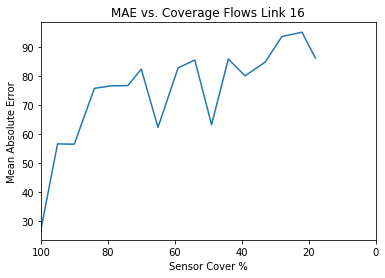

In [4]:
#run this after cell above finishes training 
plt.plot(sensors_covered, maximum_MAE)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Flows Link 16")
plt.xlim([100, 0])
#plt.savefig('/Users/alexellard/Downloads/Link16FlowsMax.png')
plt.show()

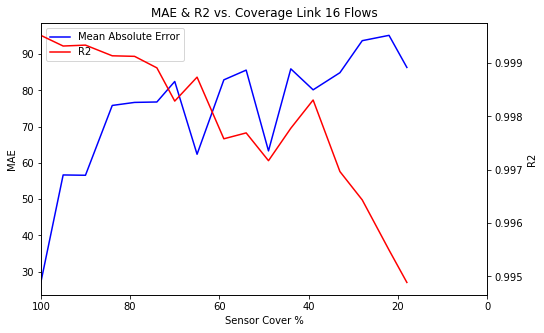

In [7]:
# Create the plot and specify the figure size
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot the first line
ax1.plot(sensors_covered, maximum_MAE, 'b-', label='Mean Absolute Error')
ax1.set_xlabel('Sensor Cover %')
ax1.set_ylabel('MAE')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the second line
ax2.plot(sensors_covered, R2_average, 'r-', label='R2')
ax2.set_ylabel('R2')

# Show legends for both lines
lines = [ax1.get_lines()[0], ax2.get_lines()[0]]
ax1.legend(lines, [line.get_label() for line in lines])

# Show the plot
plt.title("MAE & R2 vs. Coverage Link 16 Flows")
plt.xlim([100, 0])
plt.savefig('/Users/alexellard/Downloads/MAER2Flow.png')
plt.show()
